In [1]:
import os
os.chdir("/gpfs/home/asun/jin_lab/yap/pipeline0_bt2_local_alignment/split_s10")
print(os.getcwd())

/gpfs/group/jin/asun/yap/pipeline0_bt2_local_alignment/split_s10


In [2]:
import pandas as pd
import subprocess
from Bio.Seq import Seq

# Function to reverse complement if RC column is "RC"
def conditional_reverse_complement(row):
    if row["RC"] == "RC":
        return str(Seq(row["SEQ"]).reverse_complement())
    return row["SEQ"]  # Keep the sequence unchanged if not "RC"

# Load BAM into DataFrame
sam_output = subprocess.run(["samtools", "view", "intersect.bam"], capture_output=True, text=True)
sam_lines = sam_output.stdout.strip().split("\n")

# Convert SAM to DataFrame
columns = ["QNAME", "FLAG", "RNAME", "POS", "MAPQ", "CIGAR", "RNEXT", "PNEXT", "TLEN", "SEQ", "QUAL"]
data = [line.split("\t")[:11] for line in sam_lines]
df = pd.DataFrame(data, columns=columns)

# Convert FLAG to numeric
df["FLAG"] = pd.to_numeric(df["FLAG"])
df["RC"] = df["FLAG"].apply(lambda x: "RC" if x & 16 else "FORWARD")

rp_indices = pd.read_csv("/gpfs/home/asun/jin_lab/yap/raw_data/384RPIndexes.csv")
rp_indices = rp_indices.rename(columns={"RP Index": "RP_INDEX", "Position": "WELL"})   

# Apply the function to create the TRUE_SEQ column
df["TRUE_SEQ"] = df.apply(conditional_reverse_complement, axis=1)

df["RP_INDEX"] = df["TRUE_SEQ"].apply(lambda x: x[:8])

# Assign read type
df["READ_TYPE"] = df["FLAG"].apply(lambda x: "READ_1" if x & 64 else ("READ_2" if x & 128 else "UNPAIRED"))

df["READ_1"] = ""

readnames = df.loc[(df["READ_TYPE"] == "READ_2"), "QNAME"].tolist()

with open("grna_r1.fq", "r") as fq:
    while True:
        header = fq.readline().strip()  
        seq = fq.readline().strip()     
        fq.readline()                   
        fq.readline()                   
        
        if not header:
            break  # End of file
        
        qname = header.lstrip("@")

        if qname in df["QNAME"].values:
            first_8_bp = seq[:8]  # Extract the first 8 bases
            df.loc[df["QNAME"] == qname, "READ_1"] = seq
            df.loc[df["QNAME"] == qname, "RP_INDEX"] = first_8_bp


df = df.merge(rp_indices, on=["RP_INDEX"], how="left")
df_filtered = df.drop_duplicates(subset='QNAME', keep='first')
len(df_filtered)

112

In [49]:
df_filtered

QNAME  FLAG      RNAME POS MAPQ  \
0     lh00134:653:22MKYCLT4:3:1102:23021:5428   177   Foxg1_g1   1   22   
1    lh00134:653:22MKYCLT4:3:1107:31103:16231    99   Foxg1_g2   1    9   
3     lh00134:653:22MKYCLT4:3:1121:13337:8917    83   Foxg1_g1   1    9   
5    lh00134:653:22MKYCLT4:3:1130:28635:15180    99   Foxg1_g1   1   22   
7      lh00134:653:22MKYCLT4:3:1132:8677:2359    83  Dnmt3a_g1   3    9   
..                                        ...   ...        ...  ..  ...   
185  lh00134:653:22MKYCLT4:3:2463:35132:24695    83   Foxg1_g1   1   16   
187  lh00134:653:22MKYCLT4:3:2472:30326:21080    99    Safe_g1   2    9   
189   lh00134:653:22MKYCLT4:3:2473:7707:26236   153   Foxg1_g1   1    9   
190  lh00134:653:22MKYCLT4:3:2476:29622:10528    83   Foxg1_g1   1    9   
192  lh00134:653:22MKYCLT4:3:2484:35018:20351    83   Foxg1_g1   1    9   

         CIGAR RNEXT     PNEXT  TLEN  \
0    66S72M12S  chr8  30412233     0   
1    27S82M41S     =         1  -180   
3    60S73M17S     =         1   201   
5    40S44M66S     =         1  -211   
7    31S71M48S     =         3   170   
..         ...   ...       ...   ...   
185  29S73M48S     =         1   158   
187  16S71M63S     =         2  -202   
189  74S52M24S     =         1     0   
190  53S73M24S     =         1   172   
192  17S73M60S     =         1   163   

                                                   SEQ  \
0    TTACCGTAACTTGAAAGTATTTCGATTTCTTGGCTTTATATATCTT...   
1    TACTGCTCTCATTTCCCGGCCAATGCAGAGTTACAACGGGACCACG...   
3    CCCAGATCTAGACACTCGTGACTGGAGTTCAGACGTGTGCTCTTCC...   
5    ACAACAGCTTCATATATCTTGTGGAAAGGACGAAACACCGAGCGCG...   
7    GACGTGTGCTCTTCCGATCTGGGAGGAAGGATAGAACTCAAAGAAG...   
..                                                 ...   
185  TCCGATCTGGAGAGAGGAGCGAAACACTGAGCGCGTTGTAGCTGAA...   
187  ACAAGACGACACACCACTAGAAACCTAAAAATCTAGTTTTAGAGCT...   
189  ATCATATGCTTACCGTAACTTGAAAGTATTTCGATTTCTAGGCTTT...   
190  CAGACGTGTGCTCTTCCGATCTGAGGAATACTTGTGGAAAGGACGA...   
192  GCTCTTCCGATCTGGGGAGCGCGTTGTAGCTGAACGGGTTTTAGAG...   

                                                  QUAL       RC  \
0    IIIIIIIIIIIIIIIIIIIIIIIIIIIIIII9IIIIIIIIIIIIII...       RC   
1    IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...  FORWARD   
3    9II99IIIIIIIIIII9IIIIIIIIIIIIIIIIIIIIIIIIIIIII...       RC   
5    IIIIIII9IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...  FORWARD   
7    IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...       RC   
..                                                 ...      ...   
185  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...       RC   
187  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...  FORWARD   
189  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII9IIIIIIIIIII...       RC   
190  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...       RC   
192  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...       RC   

                                              TRUE_SEQ  RP_INDEX READ_TYPE  \
0    GAGGGAAATATTAAGTTGATAATGGATTAGTTTTATTTTAATTTGC...  ACAACAGC    READ_2   
1    TACTGCTCTCATTTCCCGGCCAATGCAGAGTTACAACGGGACCACG...  TACTGCTC    READ_1   
3    GCGCATATCCACTTTTTCAAGTTGATAACGGACTAGCCTTATTTTA...  GCGCATAT    READ_1   
5    ACAACAGCTTCATATATCTTGTGGAAAGGACGAAACACCGAGCGCG...  ACAACAGC    READ_1   
7    TACTGCTCCCCCTCTTCTTTGAGTTCTATGTGGTATCAAGCAGAGT...  TACTGCTC    READ_1   
..                                                 ...       ...       ...   
185  ACAACAGCTTCACCAATGCCTCTGCGCACCGACTCGGTGCCACTTT...  ACAACAGC    READ_1   
187  ACAAGACGACACACCACTAGAAACCTAAAAATCTAGTTTTAGAGCT...  ACAAGACG    READ_1   
189  GGGGAAGAGGTTAATGGATTAGTTTTATTTTAACTTGCTATTTCTA...  ACAACAGC    READ_2   
190  ACAACAGCTATCAACCCAGAGTACCAAGTTGATAACGGACTAGCCT...  ACAACAGC    READ_1   
192  GCGCATATTAACCATTCAGCTACAACGCGCTCCCCAAGCAGTGGTA...  GCGCATAT    READ_1   

                                                READ_1 WELL  
0    ACAACAGCATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTACATCTA...  J17  
1    TACTGCTCTCATTTCCCGGCCAATGCAGAGTTACAACGGGACCACG...   I1  
3    GCGCATATCCACTTTTTCAAGTTGATAA

In [52]:
df_filtered.groupby(['WELL', 'RNAME']).size()

WELL  RNAME    
B7    Safe_g1       2
C24   Dnmt3a_g1     3
C4    Foxg1_g1      2
D21   Dnmt3a_g1     1
E19   Safe_g1       1
E24   Foxg1_g1      1
F15   Foxg1_g1      2
F19   Safe_g1       3
      Safe_g2       1
F21   Safe_g2       1
F7    Safe_g2       2
G6    Safe_g1       1
H2    Foxg1_g1      2
I1    Dnmt3a_g1     2
      Foxg1_g1     17
      Foxg1_g2      2
I17   Safe_g1       3
I22   Safe_g2       1
J17   Foxg1_g1     15
      Foxg1_g2      1
J6    Dnmt3a_g1     1
K22   Dnmt3a_g1     2
K5    Foxg1_g2      2
L24   Foxg1_g1      1
M22   Safe_g1       2
N2    Dnmt3a_g1     1
N4    Dnmt3a_g1     1
N5    Safe_g2       2
O18   Dnmt3a_g2     1
O20   Foxg1_g1      5
O23   Foxg1_g1      8
O9    Safe_g2       7
dtype: int64

In [3]:
result = (
    df_filtered.groupby(['WELL', 'RNAME'])
    .size()
    .unstack(fill_value=0)
)

# This gives you the desired result
result = result.astype(int)
result = result.reset_index()


In [74]:
result

RNAME WELL  Dnmt3a_g1  Dnmt3a_g2  Foxg1_g1  Foxg1_g2  Safe_g1  Safe_g2
0       B7          0          0         0         0        2        0
1      C24          3          0         0         0        0        0
2       C4          0          0         2         0        0        0
3      D21          1          0         0         0        0        0
4      E19          0          0         0         0        1        0
5      E24          0          0         1         0        0        0
6      F15          0          0         2         0        0        0
7      F19          0          0         0         0        3        1
8      F21          0          0         0         0        0        1
9       F7          0          0         0         0        0        2
10      G6          0          0         0         0        1        0
11      H2          0          0         2         0        0        0
12      I1          2          0        17         2        0        0
13     I17          0          0         0         0        3        0
14     I22          0          0         0         0        0        1
15     J17          0          0        15         1        0        0
16      J6          1          0         0         0        0        0
17     K22          2          0         0         0        0        0
18      K5          0          0         0         2        0        0
19     L24          0          0         1         0        0        0
20     M22          0          0         0         0        2        0
21      N2          1          0         0         0        0        0
22      N4          1          0         0         0        0        0
23      N5          0          0         0         0        0        2
24     O18          0          1         0         0        0        0
25     O20          0          0         5         0        0        0
26     O23          0          0         8         0        0        0
27      O9          0          0         0         0        0        7

In [78]:
import pandas as pd

# df1 with RandomIndex
df1 = pd.DataFrame({'RandomIndex': ['A1', 'A2', 'A3']})

# df2 with WELLS and some values
df2 = pd.DataFrame({'WELL': ['A1'], 'Foxg1_g1': [10]})

# Perform a left join
merged_df = pd.merge(df1, df2, how='left', left_on='RandomIndex', right_on='WELL')
print(merged_df)
# Drop redundant WELL column
merged_df = merged_df.drop(columns='WELL')

# Fill NaNs with 0 and convert to integers
merged_df = merged_df.fillna(0)
merged_df[df2.columns[1:]] = merged_df[df2.columns[1:]].astype(int)

print(merged_df)

  RandomIndex WELL  Foxg1_g1
0          A1   A1      10.0
1          A2  NaN       NaN
2          A3  NaN       NaN
  RandomIndex  Foxg1_g1
0          A1        10
1          A2         0
2          A3         0


In [82]:
df1['RandomIndex']

0    A1
1    A2
2    A3
Name: RandomIndex, dtype: object

In [79]:
mapping_summary["RandomIndex"]

cell_id
S_10-1-A1-A1      A1
S_10-1-A1-A13    A13
S_10-1-A1-A14    A14
S_10-1-A1-A2      A2
S_10-1-A1-B1      B1
                ... 
S_10-2-A1-O4      O4
S_10-2-A1-P15    P15
S_10-2-A1-P16    P16
S_10-2-A1-P3      P3
S_10-2-A1-P4      P4
Name: RandomIndex, Length: 384, dtype: object

In [80]:
result["WELL"]

0      B7
1     C24
2      C4
3     D21
4     E19
5     E24
6     F15
7     F19
8     F21
9      F7
10     G6
11     H2
12     I1
13    I17
14    I22
15    J17
16     J6
17    K22
18     K5
19    L24
20    M22
21     N2
22     N4
23     N5
24    O18
25    O20
26    O23
27     O9
Name: WELL, dtype: object

In [90]:
merged_local_mapping[merged_local_mapping["RandomIndex"] == "B7"]


Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384 Plate.1  \
262  S_10       A1               4          B7       6       1    S_10   

    PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  GenesDetected  \
262         A1                 4            B7  ...           1037   

     DNAReadsYield  RNAReadsYield  RNA/(DNA+RNA)  Dnmt3a_g1  Dnmt3a_g2  \
262        0.00001       0.021629       1.667565          0          0   

     Foxg1_g1  Foxg1_g2  Safe_g1  Safe_g2  
262         0         0        2        0  

[1 rows x 110 columns]

In [93]:
merged_local_mapping["Foxg1_g1"]

0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Name: Foxg1_g1, Length: 384, dtype: int64

In [94]:
mapping_summary

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384  \
cell_id                                                                    
S_10-1-A1-A1   S_10       A1               1          A1       0       0   
S_10-1-A1-A13  S_10       A1               1         A13      12       0   
S_10-1-A1-A14  S_10       A1               1         A14      13       0   
S_10-1-A1-A2   S_10       A1               1          A2       1       0   
S_10-1-A1-B1   S_10       A1               1          B1       0       1   
...             ...      ...             ...         ...     ...     ...   
S_10-2-A1-O4   S_10       A1               2          O4       3      14   
S_10-2-A1-P15  S_10       A1               2         P15      14      15   
S_10-2-A1-P16  S_10       A1               2         P16      15      15   
S_10-2-A1-P3   S_10       A1               2          P3       2      15   
S_10-2-A1-P4   S_10       A1               2          P4       3      15   

              Plate.1 PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  \
cell_id                                                           ...   
S_10-1-A1-A1     S_10         A1                 1            A1  ...   
S_10-1-A1-A13    S_10         A1                 1           A13  ...   
S_10-1-A1-A14    S_10         A1                 1           A14  ...   
S_10-1-A1-A2     S_10         A1                 1            A2  ...   
S_10-1-A1-B1     S_10         A1                 1            B1  ...   
...               ...        ...               ...           ...  ...   
S_10-2-A1-O4     S_10         A1                 2            O4  ...   
S_10-2-A1-P15    S_10         A1                 2           P15  ...   
S_10-2-A1-P16    S_10         A1                 2           P16  ...   
S_10-2-A1-P3     S_10         A1                 2            P3  ...   
S_10-2-A1-P4     S_10         A1                 2            P4  ...   

               FinalCountedReads  FinalRNAReads  RNAUniqueMappedReads  \
cell_id                                                                 
S_10-1-A1-A1                8897          10144                 10808   
S_10-1-A1-A13              67991          79858                 87159   
S_10-1-A1-A14              95048         109880                118664   
S_10-1-A1-A2                3996           4520                  4783   
S_10-1-A1-B1                1131           1296                  1390   
...                          ...            ...                   ...   
S_10-2-A1-O4                7077           8177                  8988   
S_10-2-A1-P15              94655         108547                118343   
S_10-2-A1-P16              54334          63008                 70052   
S_10-2-A1-P3                9554          10780                 11526   
S_10-2-A1-P4               10294          11615                 12538   

               SelectedRNAReadsRatio  CellInputReadPairs  CellBarcodeRatio  \
cell_id                                                                      
S_10-1-A1-A1                0.938564              157489          0.001283   
S_10-1-A1-A13               0.916234              149171          0.001215   
S_10-1-A1-A14               0.925976              220693          0.001798   
S_10-1-A1-A2                0.945014              191069          0.001556   
S_10-1-A1-B1                0.932374              147158          0.001199   
...                              ...                 ...               ...   
S_10-2-A1-O4                0.909769              394485          0.003213   
S_10-2-A1-P15               0.917224              216958          0.001767   
S_10-2-A1-P16               0.899446              146532          0.001194   
S_10-2-A1-P3                0.935277              614043          0.005002   
S_10-2-A1-P4                0.926384              883536          0.007197   

               GenesDetected  DNAReadsYield  RNAReadsYield  RNA/(DNA+RNA)  
cell_id                           

In [9]:
import numpy as np

In [ ]:
merged_local_mapping = pd.merge(mapping_summary, result, how="left", left_on="RandomIndex", right_on="WELL")
#merged_local_mapping.index = mapping_summary.index
merged_local_mapping = merged_local_mapping.drop(columns='WELL')
#merged_local_mapping = merged_local_mapping.fillna(0)
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].fillna(0).astype(int)
merged_local_mapping

NameError: name 'np' is not defined

In [11]:
merged_local_mapping = pd.merge(mapping_summary, result, how="left", left_on="RandomIndex", right_on="WELL")
#merged_local_mapping.index = mapping_summary.index
merged_local_mapping = merged_local_mapping.drop(columns='WELL')
#merged_local_mapping = merged_local_mapping.fillna(0)

merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].fillna(0).astype(int)
merged_local_mapping["Total_grna"] = merged_local_mapping[result.columns[1:]].sum(axis=1)
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].replace(0, np.nan)
merged_local_mapping["Total_grna"] = merged_local_mapping["Total_grna"].replace(0, np.nan)
merged_local_mapping

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384 Plate.1  \
0    S_10       A1               1          A1       0       0    S_10   
1    S_10       A1               1         A13      12       0    S_10   
2    S_10       A1               1         A14      13       0    S_10   
3    S_10       A1               1          A2       1       0    S_10   
4    S_10       A1               1          B1       0       1    S_10   
..    ...      ...             ...         ...     ...     ...     ...   
379  S_10       A1               2          O4       3      14    S_10   
380  S_10       A1               2         P15      14      15    S_10   
381  S_10       A1               2         P16      15      15    S_10   
382  S_10       A1               2          P3       2      15    S_10   
383  S_10       A1               2          P4       3      15    S_10   

    PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  DNAReadsYield  \
0           A1                 1            A1  ...       0.000025   
1           A1                 1           A13  ...       0.000345   
2           A1                 1           A14  ...       0.000261   
3           A1                 1            A2  ...       0.000021   
4           A1                 1            B1  ...       0.000003   
..         ...               ...           ...  ...            ...   
379         A1                 2            O4  ...       0.000018   
380         A1                 2           P15  ...       0.000267   
381         A1                 2           P16  ...       0.000369   
382         A1                 2            P3  ...       0.000011   
383         A1                 2            P4  ...       0.000005   

     RNAReadsYield  RNA/(DNA+RNA)  Dnmt3a_g1  Dnmt3a_g2  Foxg1_g1  Foxg1_g2  \
0         0.064411       1.624600        NaN        NaN       NaN       NaN   
1         0.535345       1.746064        NaN        NaN       NaN       NaN   
2         0.497886       1.774118        NaN        NaN       NaN       NaN   
3         0.023656       1.674074        NaN        NaN       NaN       NaN   
4         0.008807       1.703022        NaN        NaN       NaN       NaN   
..             ...            ...        ...        ...       ...       ...   
379       0.020728       1.696121        NaN        NaN       NaN       NaN   
380       0.500313       1.917250        NaN        NaN       NaN       NaN   
381       0.429995       1.849478        NaN        NaN       NaN       NaN   
382       0.017556       1.691777        NaN        NaN       NaN       NaN   
383       0.013146       1.718449        NaN        NaN       NaN       NaN   

     Safe_g1  Safe_g2  Total_grna  
0        NaN      NaN         NaN  
1        NaN      NaN         NaN  
2        NaN      NaN         NaN  
3        NaN      NaN         NaN  
4        NaN      NaN         NaN  
..       ...      ...         ...  
379      NaN      NaN         NaN  
380      NaN      NaN         NaN  
381      NaN      NaN         NaN  
382      NaN      NaN         NaN  
383      NaN      NaN         NaN  

[384 rows x 111 columns]

In [116]:
merged_local_mapping = pd.merge(mapping_summary, result, left_on="RandomIndex", right_on="WELL")
#merged_local_mapping.index = mapping_summary.index
#merged_local_mapping = merged_local_mapping.drop(columns='WELL')
#merged_local_mapping = merged_local_mapping.fillna(0)
merged_local_mapping[result.columns[1:]] = merged_local_mapping[result.columns[1:]].astype(int)
merged_local_mapping

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384 Plate.1  \
0   S_10       A1               1          H2       1       7    S_10   
1   S_10       A1               1          I1       0       8    S_10   
2   S_10       A1               1          N2       1      13    S_10   
3   S_10       A1               3          G6       5       6    S_10   
4   S_10       A1               3         I17      16       8    S_10   
5   S_10       A1               3         J17      16       9    S_10   
6   S_10       A1               3          J6       5       9    S_10   
7   S_10       A1               3          K5       4      10    S_10   
8   S_10       A1               3          N5       4      13    S_10   
9   S_10       A1               3         O18      17      14    S_10   
10  S_10       A1               5         D21      20       3    S_10   
11  S_10       A1               5         F21      20       5    S_10   
12  S_10       A1               5         I22      21       8    S_10   
13  S_10       A1               5         K22      21      10    S_10   
14  S_10       A1               5         M22      21      12    S_10   
15  S_10       A1               5          O9       8      14    S_10   
16  S_10       A1               6         C24      23       2    S_10   
17  S_10       A1               6         E24      23       4    S_10   
18  S_10       A1               6         L24      23      11    S_10   
19  S_10       A1               6         O23      22      14    S_10   
20  S_10       A1               4          B7       6       1    S_10   
21  S_10       A1               4         E19      18       4    S_10   
22  S_10       A1               4         F19      18       5    S_10   
23  S_10       A1               4          F7       6       5    S_10   
24  S_10       A1               4         O20      19      14    S_10   
25  S_10       A1               2          C4       3       2    S_10   
26  S_10       A1               2         F15      14       5    S_10   
27  S_10       A1               2          N4       3      13    S_10   

   PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  DNAReadsYield  \
0          A1                 1            H2  ...       0.000022   
1          A1                 1            I1  ...       0.000009   
2          A1                 1            N2  ...       0.000015   
3          A1                 3            G6  ...       0.000012   
4          A1                 3           I17  ...       0.000215   
5          A1                 3           J17  ...       0.000228   
6          A1                 3            J6  ...       0.000015   
7          A1                 3            K5  ...       0.000009   
8          A1                 3            N5  ...       0.000009   
9          A1                 3           O18  ...       0.000228   
10         A1                 5           D21  ...       0.000152   
11         A1                 5           F21  ...       0.000223   
12         A1                 5           I22  ...       0.000200   
13         A1                 5           K22  ...       0.000275   
14         A1                 5           M22  ...       0.000291   
15         A1                 5            O9  ...       0.000319   
16         A1                 6           C24  ...       0.000252   
17         A1                 6           E24  ...       0.000212   
18         A1                 6           L24  ...       0.000237   
19         A1                 6           O23  ...       0.000226   
20         A1                 4            B7  ...       0.000010   
21         A1                 4           E19  ...       0.000211   
22         A1                 4           F19  ...       0.000202   
23         A1                 4            F7  ...       0.000037   
24         A1                 4           O20  ...       0.000205   
25         A1                 2            C4  ...       0.000012   
26         A1         

In [120]:
merged_local_mapping["Foxg1_g1"]

0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Name: Foxg1_g1, Length: 384, dtype: int64

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from cemba_data.mapping import cutoff_vs_cell_remain, plot_on_plate


def test_xlim(data, hue, color_quantile=color_quantile, config=config):
    vmin = data[hue].min()
    vmax = data[hue].max()
    print(vmin, vmax)
    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=0,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    return

1.0 21.0


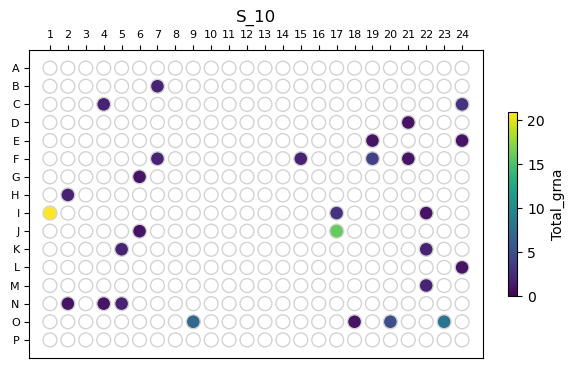

In [14]:
test_xlim(merged_local_mapping, hue="Total_grna")
#distplot_and_plate_view(merged_local_mapping, hue='Dnmt3a_g2')

## Prepare

In [2]:
output_dir = ''
plate_col = 'Plate'
color_quantile = (0.025, 0.975)

In [3]:
# Parameters
output_dir = "/gpfs/group/jin/asun/yap/pipeline2_yap_s10/yap_demultiplex"


### Load

In [4]:
import pathlib
import pandas as pd
from cemba_data.utilities import get_configuration

output_dir = pathlib.Path(output_dir)
mapping_summary = pd.read_csv(output_dir / 'stats/MappingSummary.csv.gz', index_col=0)
config = get_configuration(output_dir / 'mapping_config.ini')

In [5]:
mapping_summary
gene_counts=pd.read_hdf(output_dir / 'TotalRNAData.h5', index_col=0, key='data')


In [34]:
list(merged_mapping.columns)

['Plate',
 'PCRIndex',
 'MultiplexGroup',
 'RandomIndex',
 'Col384',
 'Row384',
 'Plate.1',
 'PCRIndex.1',
 'MultiplexGroup.1',
 'RandomIndex.1',
 'Col384.1',
 'Row384.1',
 'R1InputReads',
 'R1WithR1Adapter',
 'R1WithTSO',
 'R1WithN6',
 'R1WithTSO_rc',
 'R1WithN6_rc',
 'R1With3PpolyT',
 'R1With5PpolyT',
 'R1With3PpolyA',
 'R1With5PpolyA',
 'R1WithpolyTLong',
 'R1WithpolyALong',
 'R1WithISPCR_F',
 'R1WithISPCR_R',
 'R1QualTrimBP',
 'R1TrimmedReads',
 'R1TrimmedReadsBP',
 'R1TrimmedReadsRate',
 'R1UniqueMappedReads',
 'R1MappingRate',
 'R1UnmappedReads',
 'R1UnuniqueMappedReads',
 'R1OT',
 'R1OB',
 'R1CTOT',
 'R1CTOB',
 'R1TotalC',
 'R1TotalmCGRate',
 'R1TotalmCHGRate',
 'R1TotalmCHHRate',
 'R1MAPQFilteredReads',
 'R1DuplicatedReads',
 'R1DuplicationRate',
 'R1FinalBismarkReads',
 'R2InputReads',
 'R2WithR1Adapter',
 'R2WithTSO',
 'R2WithN6',
 'R2WithTSO_rc',
 'R2WithN6_rc',
 'R2With3PpolyT',
 'R2With5PpolyT',
 'R2With3PpolyA',
 'R2With5PpolyA',
 'R2WithpolyTLong',
 'R2WithpolyALong',
 '

In [63]:
merged_mapping["Foxg1_g1"]

S_10-1-A1-A1     0
S_10-1-A1-A13    0
S_10-1-A1-A14    0
S_10-1-A1-A2     0
S_10-1-A1-B1     0
                ..
S_10-2-A1-O4     0
S_10-2-A1-P15    0
S_10-2-A1-P16    0
S_10-2-A1-P3     0
S_10-2-A1-P4     0
Name: Foxg1_g1, Length: 384, dtype: int64

In [6]:
merged_mapping = pd.merge(mapping_summary, gene_counts, left_index=True, right_index=True)
merged_mapping

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384  \
S_10-1-A1-A1   S_10       A1               1          A1       0       0   
S_10-1-A1-A13  S_10       A1               1         A13      12       0   
S_10-1-A1-A14  S_10       A1               1         A14      13       0   
S_10-1-A1-A2   S_10       A1               1          A2       1       0   
S_10-1-A1-B1   S_10       A1               1          B1       0       1   
...             ...      ...             ...         ...     ...     ...   
S_10-2-A1-O4   S_10       A1               2          O4       3      14   
S_10-2-A1-P15  S_10       A1               2         P15      14      15   
S_10-2-A1-P16  S_10       A1               2         P16      15      15   
S_10-2-A1-P3   S_10       A1               2          P3       2      15   
S_10-2-A1-P4   S_10       A1               2          P4       3      15   

              Plate.1 PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  \
S_10-1-A1-A1     S_10         A1                 1            A1  ...   
S_10-1-A1-A13    S_10         A1                 1           A13  ...   
S_10-1-A1-A14    S_10         A1                 1           A14  ...   
S_10-1-A1-A2     S_10         A1                 1            A2  ...   
S_10-1-A1-B1     S_10         A1                 1            B1  ...   
...               ...        ...               ...           ...  ...   
S_10-2-A1-O4     S_10         A1                 2            O4  ...   
S_10-2-A1-P15    S_10         A1                 2           P15  ...   
S_10-2-A1-P16    S_10         A1                 2           P16  ...   
S_10-2-A1-P3     S_10         A1                 2            P3  ...   
S_10-2-A1-P4     S_10         A1                 2            P4  ...   

               ENSMUSG00000118388.1  ENSMUSG00000118389.1  \
S_10-1-A1-A1                      0                     0   
S_10-1-A1-A13                     0                     0   
S_10-1-A1-A14                     0                     0   
S_10-1-A1-A2                      0                     0   
S_10-1-A1-B1                      0                     0   
...                             ...                   ...   
S_10-2-A1-O4                      0                     0   
S_10-2-A1-P15                     0                     0   
S_10-2-A1-P16                     0                     0   
S_10-2-A1-P3                      0                     0   
S_10-2-A1-P4                      0                     0   

               ENSMUSG00000118390.1  ENSMUSG00000118391.1  \
S_10-1-A1-A1                      0                     0   
S_10-1-A1-A13                     0                     0   
S_10-1-A1-A14                     0                     0   
S_10-1-A1-A2                      0                     0   
S_10-1-A1-B1                      0                     0   
...                             ...                   ...   
S_10-2-A1-O4                      0                     0   
S_10-2-A1-P15                     0                     0   
S_10-2-A1-P16                     0                     0   
S_10-2-A1-P3                      0                     0   
S_10-2-A1-P4                      0                     0   

               ENSMUSG00000118392.1  ENSMUSG00000118393.1  Foxg1_g1  Foxg1_g2  \
S_10-1-A1-A1                      0                     0         0         2   
S_10-1-A1-A13                     0                     0         0         0   
S_10-1-A1-A14                     0                     0         0         0   
S_10-1-A1-A2                      0                     0         0         3   
S_10-1-A1-B1                      0                     0         0         0   
...                             ...                   ...       ...       ...   
S_10-2-A1-O4                      0                     0         0         1   
S_10-2-A1-P15                     0                     0         0         0   
S_10-2-A1-P16                

In [9]:
import numpy as np

In [10]:
target_cols = ["Foxg1_g1", "Foxg1_g2", "Dnmt3a_g1", "Dnmt3a_g2", "Safe_g1", "Safe_g2"]

merged_mapping[target_cols] = merged_mapping[target_cols].fillna(0).astype(int)
merged_mapping["Total_grna"] = merged_mapping[target_cols].sum(axis=1)
merged_mapping[target_cols] = merged_mapping[target_cols].replace(0, np.nan)
merged_mapping["Total_grna"] = merged_mapping["Total_grna"].replace(0, np.nan)

In [7]:
def visualize_local(data, hue):
    vmax = data[hue].max()
    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=0,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    return

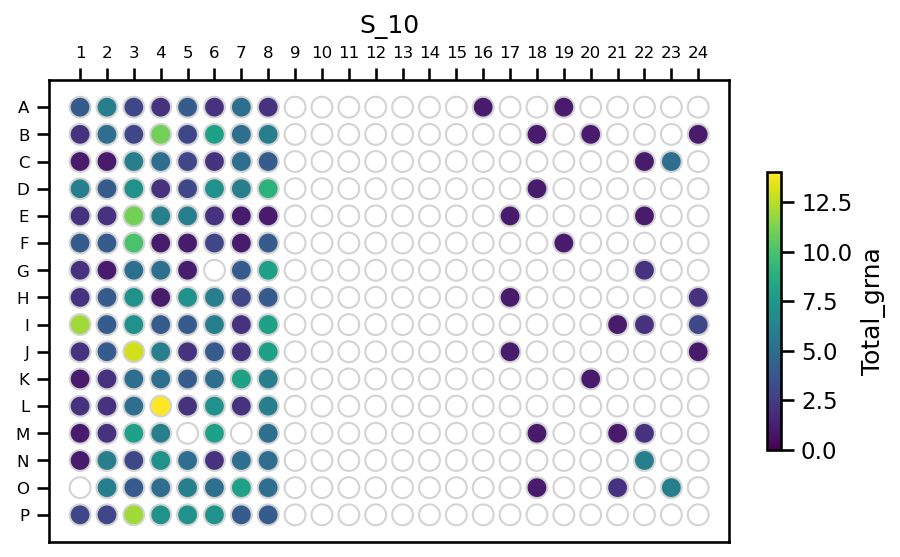

In [14]:
visualize_local(merged_mapping, "Total_grna")

In [1]:
import mygene


/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)
/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/seaborn/distributions.py:2464: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:143: UserWa

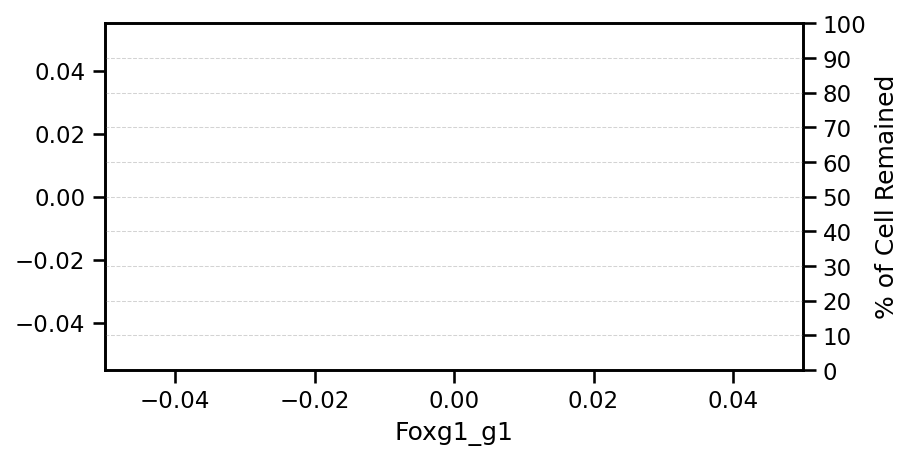

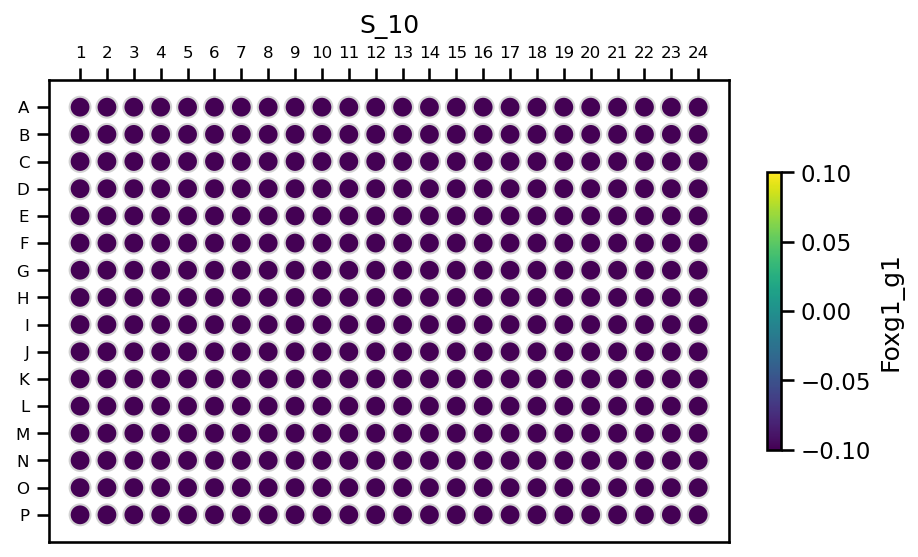

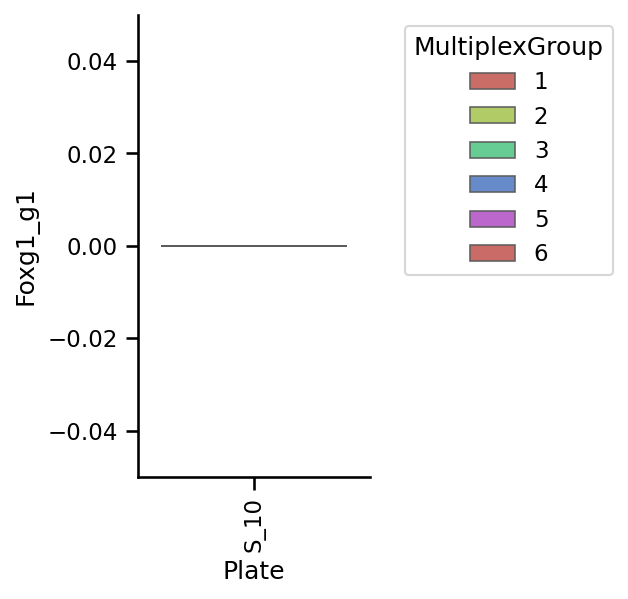

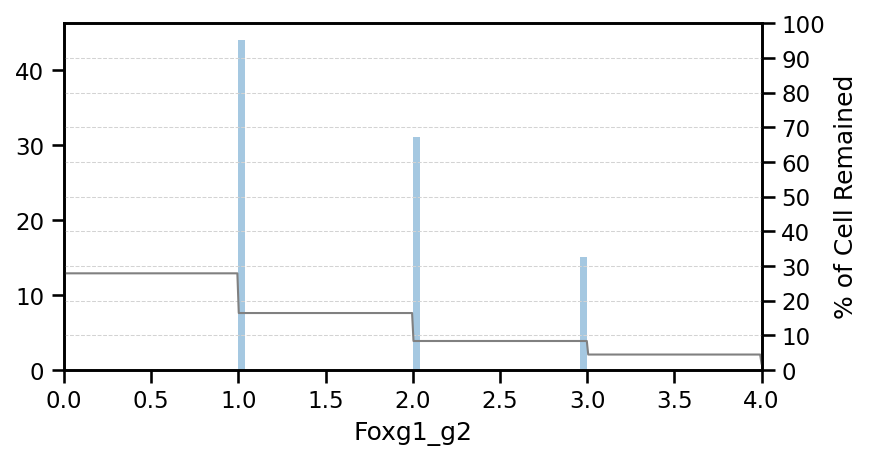

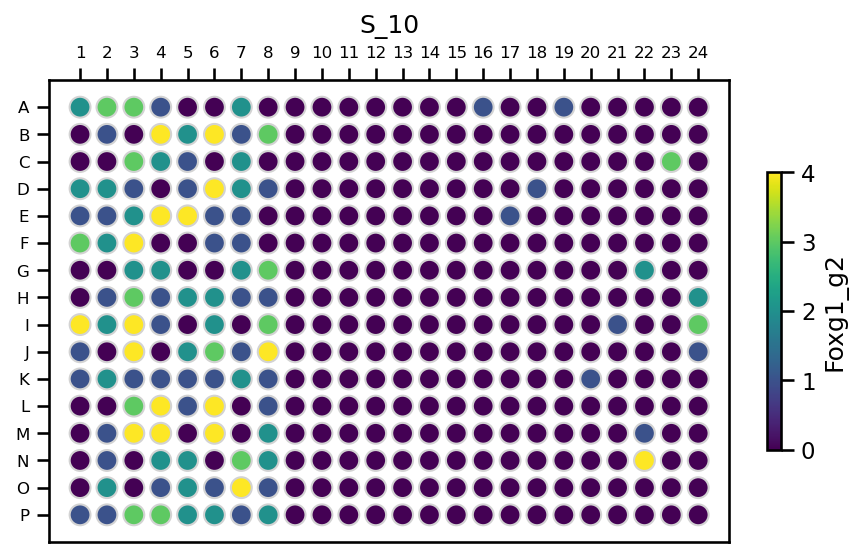

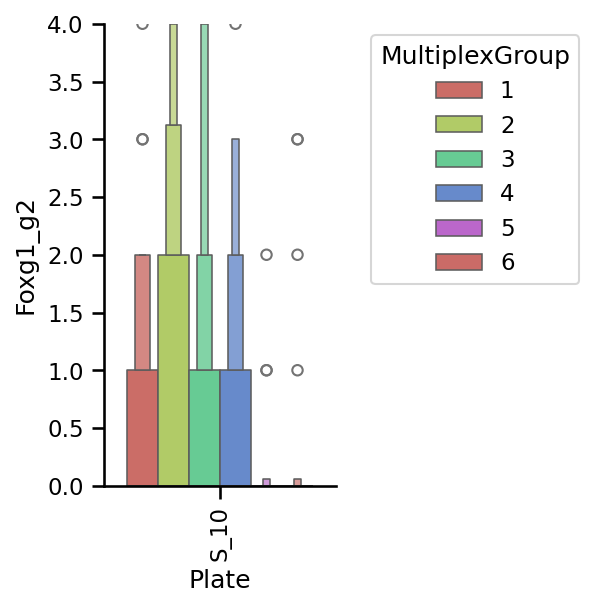

In [138]:
distplot_and_plate_view(merged_mapping, hue='Foxg1_g1')
distplot_and_plate_view(merged_mapping, hue='Foxg1_g2')

In [14]:
mg = mygene.MyGeneInfo()
#gene_names = gene_counts.columns.to_list()

In [18]:
ensembl_ids

['Dnmt3a_g1',
 'Dnmt3a_g2',
 'ENSMUSG00000000001.4',
 'ENSMUSG00000000003.15',
 'ENSMUSG00000000028.15',
 'ENSMUSG00000000031.16',
 'ENSMUSG00000000037.16',
 'ENSMUSG00000000049.11',
 'ENSMUSG00000000056.7',
 'ENSMUSG00000000058.6',
 'ENSMUSG00000000078.7',
 'ENSMUSG00000000085.16',
 'ENSMUSG00000000088.7',
 'ENSMUSG00000000093.6',
 'ENSMUSG00000000094.12',
 'ENSMUSG00000000103.12',
 'ENSMUSG00000000120.6',
 'ENSMUSG00000000125.5',
 'ENSMUSG00000000126.11',
 'ENSMUSG00000000127.15',
 'ENSMUSG00000000131.15',
 'ENSMUSG00000000134.17',
 'ENSMUSG00000000142.15',
 'ENSMUSG00000000148.17',
 'ENSMUSG00000000149.10',
 'ENSMUSG00000000154.16',
 'ENSMUSG00000000157.16',
 'ENSMUSG00000000159.16',
 'ENSMUSG00000000167.14',
 'ENSMUSG00000000168.9',
 'ENSMUSG00000000171.5',
 'ENSMUSG00000000182.9',
 'ENSMUSG00000000183.6',
 'ENSMUSG00000000184.12',
 'ENSMUSG00000000194.13',
 'ENSMUSG00000000197.8',
 'ENSMUSG00000000202.9',
 'ENSMUSG00000000204.16',
 'ENSMUSG00000000214.11',
 'ENSMUSG00000000215.11'

In [30]:
result = mg.querymany("Dnmt3a_g1", scopes="ensembl.gene", fields="symbol", species="mouse", as_dataframe=True)


querying 1-1...done.
Finished.
1 input query terms found no hit:
	['Dnmt3a_g1']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [29]:
result


_id    _score symbol
query                                     
ENSMUSG00000000093  21385  27.47623   Tbx2

In [19]:
result = mg.querymany(ensembl_ids[1:1000], scopes="ensembl.gene", fields="symbol,ucsc", species="human")


querying 1-999...done.
Finished.
999 input query terms found no hit:
	['Dnmt3a_g2', 'ENSMUSG00000000001.4', 'ENSMUSG00000000003.15', 'ENSMUSG00000000028.15', 'ENSMUSG0000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [16]:
result


NameError: name 'result' is not defined

In [12]:
ensembl_ids = gene_counts.columns.to_list()


In [31]:
mapping_summary

Plate PCRIndex  MultiplexGroup RandomIndex  Col384  Row384  \
cell_id                                                                    
S_10-1-A1-A1   S_10       A1               1          A1       0       0   
S_10-1-A1-A13  S_10       A1               1         A13      12       0   
S_10-1-A1-A14  S_10       A1               1         A14      13       0   
S_10-1-A1-A2   S_10       A1               1          A2       1       0   
S_10-1-A1-B1   S_10       A1               1          B1       0       1   
...             ...      ...             ...         ...     ...     ...   
S_10-2-A1-O4   S_10       A1               2          O4       3      14   
S_10-2-A1-P15  S_10       A1               2         P15      14      15   
S_10-2-A1-P16  S_10       A1               2         P16      15      15   
S_10-2-A1-P3   S_10       A1               2          P3       2      15   
S_10-2-A1-P4   S_10       A1               2          P4       3      15   

              Plate.1 PCRIndex.1  MultiplexGroup.1 RandomIndex.1  ...  \
cell_id                                                           ...   
S_10-1-A1-A1     S_10         A1                 1            A1  ...   
S_10-1-A1-A13    S_10         A1                 1           A13  ...   
S_10-1-A1-A14    S_10         A1                 1           A14  ...   
S_10-1-A1-A2     S_10         A1                 1            A2  ...   
S_10-1-A1-B1     S_10         A1                 1            B1  ...   
...               ...        ...               ...           ...  ...   
S_10-2-A1-O4     S_10         A1                 2            O4  ...   
S_10-2-A1-P15    S_10         A1                 2           P15  ...   
S_10-2-A1-P16    S_10         A1                 2           P16  ...   
S_10-2-A1-P3     S_10         A1                 2            P3  ...   
S_10-2-A1-P4     S_10         A1                 2            P4  ...   

               FinalCountedReads  FinalRNAReads  RNAUniqueMappedReads  \
cell_id                                                                 
S_10-1-A1-A1                8897          10144                 10808   
S_10-1-A1-A13              67991          79858                 87159   
S_10-1-A1-A14              95048         109880                118664   
S_10-1-A1-A2                3996           4520                  4783   
S_10-1-A1-B1                1131           1296                  1390   
...                          ...            ...                   ...   
S_10-2-A1-O4                7077           8177                  8988   
S_10-2-A1-P15              94655         108547                118343   
S_10-2-A1-P16              54334          63008                 70052   
S_10-2-A1-P3                9554          10780                 11526   
S_10-2-A1-P4               10294          11615                 12538   

               SelectedRNAReadsRatio  CellInputReadPairs  CellBarcodeRatio  \
cell_id                                                                      
S_10-1-A1-A1                0.938564              157489          0.001283   
S_10-1-A1-A13               0.916234              149171          0.001215   
S_10-1-A1-A14               0.925976              220693          0.001798   
S_10-1-A1-A2                0.945014              191069          0.001556   
S_10-1-A1-B1                0.932374              147158          0.001199   
...                              ...                 ...               ...   
S_10-2-A1-O4                0.909769              394485          0.003213   
S_10-2-A1-P15               0.917224              216958          0.001767   
S_10-2-A1-P16               0.899446              146532          0.001194   
S_10-2-A1-P3                0.935277              614043          0.005002   
S_10-2-A1-P4                0.926384              883536          0.007197   

               GenesDetected  DNAReadsYield  RNAReadsYield  RNA/(DNA+RNA)  
cell_id                           

In [32]:
df

Geneid         Dnmt3a_g1  Dnmt3a_g2  ENSMUSG00000000001.4  \
S_10-1-A1-D1           2          1                     0   
S_10-1-A1-C2           0          0                     0   
S_10-1-A1-F13          0          0                    15   
S_10-1-A1-J2           0          1                     0   
S_10-1-A1-F14          0          0                     1   
...                  ...        ...                   ...   
S_10-2-A1-F3           2          2                     0   
S_10-2-A1-L4           1          6                     0   
S_10-2-A1-B4           3          0                     0   
S_10-2-A1-B16          0          0                     1   
S_10-2-A1-K16          0          0                     0   

Geneid         ENSMUSG00000000003.15  ENSMUSG00000000028.15  \
S_10-1-A1-D1                       0                      0   
S_10-1-A1-C2                       0                      0   
S_10-1-A1-F13                      0                      0   
S_10-1-A1-J2                       0                      0   
S_10-1-A1-F14                      0                      1   
...                              ...                    ...   
S_10-2-A1-F3                       0                      0   
S_10-2-A1-L4                       0                      0   
S_10-2-A1-B4                       0                      0   
S_10-2-A1-B16                      0                      0   
S_10-2-A1-K16                      0                      0   

Geneid         ENSMUSG00000000031.16  ENSMUSG00000000037.16  \
S_10-1-A1-D1                       0                      0   
S_10-1-A1-C2                       0                      0   
S_10-1-A1-F13                      0                      0   
S_10-1-A1-J2                       0                      0   
S_10-1-A1-F14                      0                      0   
...                              ...                    ...   
S_10-2-A1-F3                       0                      0   
S_10-2-A1-L4                       0                      0   
S_10-2-A1-B4                       0                      0   
S_10-2-A1-B16                      0                     11   
S_10-2-A1-K16                      0                      0   

Geneid         ENSMUSG00000000049.11  ENSMUSG00000000056.7  \
S_10-1-A1-D1                       0                     0   
S_10-1-A1-C2                       0                     0   
S_10-1-A1-F13                      0                     0   
S_10-1-A1-J2                       0                     0   
S_10-1-A1-F14                      0                     7   
...                              ...                   ...   
S_10-2-A1-F3                       0                     0   
S_10-2-A1-L4                       0                     0   
S_10-2-A1-B4                       0                     0   
S_10-2-A1-B16                      0                     0   
S_10-2-A1-K16                      0                     0   

Geneid         ENSMUSG00000000058.6  ...  ENSMUSG00000118388.1  \
S_10-1-A1-D1                      0  ...                     0   
S_10-1-A1-C2                      0  ...                     0   
S_10-1-A1-F13                     0  ...                     0   
S_10-1-A1-J2                      0  ...                     0   
S_10-1-A1-F14                     0  ...                     0   
...                             ...  ...                   ...   
S_10-2-A1-F3                      0  ...                     0   
S_10-2-A1-L4                      0  ...                     0   
S_10-2-A1-B4                      0  ...                     0   
S_10-2-A1-B16                     0  ...                     0   
S_10-2-A1-K16                     0  ...                     0   

Geneid         ENSMUSG00000118389.1  ENSMUSG00000118390.1  \
S_10-1-A1-D1                      0                     0   
S_10-1-A1-C2                      0                     0   
S_10-1-A1-F13                   

### Plot

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from cemba_data.mapping import cutoff_vs_cell_remain, plot_on_plate


def distplot_and_plate_view(data, hue, color_quantile=color_quantile, config=config):
    fig1, (vmin, vmax) = cutoff_vs_cell_remain(data=data[hue].dropna(), 
                                               bins=50, kde=False,
                                               xlim_quantile=color_quantile)

    fig2, plate_names, plate_datas = plot_on_plate(
        data=data,
        hue=hue,
        groupby=plate_col,
        vmin=vmin,
        vmax=vmax,
        aggregation_func=lambda i: i.mean())
    
    fig3, ax = plt.subplots(figsize=(data[plate_col].unique().size * 2, 4))
    plate_hue_name = 'MultiplexGroup' if config['barcode_version'] == 'V2' else 'RandomIndex'
    sns.boxenplot(data=data, x=plate_col, y=hue, palette='hls', 
                  ax=ax, hue=plate_hue_name)
    ax.set_ylim(vmin, vmax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.legend(bbox_to_anchor=(1.1, 1), title=plate_hue_name)
    sns.despine(ax=ax)
    return

In [13]:
# plot defaults
sns.set_context(context='notebook')
plt.rc('figure', dpi=150)

## Summary

In [7]:
# conventional basic check, change as you need
mccc_cutoff = 0.03
high_mccc = mapping_summary['mCCCFrac'] > mccc_cutoff

miseq_guess = mapping_summary['FinalDNAReads'].mean() < 50000
reads_cutoff = 100 if miseq_guess else 500000
low_reads = mapping_summary['FinalDNAReads'] < reads_cutoff

success = ~high_mccc & ~low_reads
n_cell = mapping_summary.shape[0]
n_plate = mapping_summary['Plate'].unique().size
total_wells = n_plate * 384

In [8]:
print(f"""
This library seems to be a {'MiSeq' if miseq_guess else 'NovaSeq'} library.

Cells
    {n_plate}\t plates
    {total_wells}\t wells (total cell number in theory)

    {n_cell} ({n_cell / total_wells * 100:.1f}%)\t cells having mapping metric
    {success.sum()} ({success.sum() / total_wells * 100:.1f}%)\t cells passed basic QC (mCCC and # of final reads)
    {high_mccc.sum()} ({high_mccc.sum() / total_wells * 100:.1f}%)\tcells having high mCCC frac (> {mccc_cutoff})
    {low_reads.sum()} ({low_reads.sum() / total_wells * 100:.1f}%)\tcells having low number of final mC reads (< {reads_cutoff}).

Reads
    {mapping_summary['CellInputReadPairs'].sum()*2:.0f}\tTotal Input Reads (R1 & R2)
    {mapping_summary['CellInputReadPairs'].mean()*2:.0f}\tAverage Input Reads for cells having metric (R1 & R2)
    
    {mapping_summary['FinalDNAReads'].sum():.0f}\tTotal Final DNA Reads (R1 & R2)
    {mapping_summary['FinalDNAReads'].mean():.0f}\tAverage Final DNA Reads for cells having metric (R1 & R2)
    {mapping_summary['FinalRNAReads'].sum():.0f}\tTotal Final RNA Reads (R1)
    {mapping_summary['FinalRNAReads'].mean():.0f}\tAverage Final RNA Reads for cells having metric (R1)
    {mapping_summary['GenesDetected'].mean():.0f}\tAverage Genes Detected for cells having metric (R1)
""")

    # {mapping_summary['DNAOverallMappingRate'].mean():.1f}%\tDNAOverallMappingRate for cells having metric
    # {mapping_summary['RNAOverallMappingRate'].mean():.1f}%\tRNAOverallMappingRate for cells having metric
    # {mapping_summary['DNAUniqueAlignPCRDuplicationRate'].mean() * 100:.1f}%\tDNAUniqueAlignPCRDuplicationRate for cells having metric


This library seems to be a MiSeq library.

Cells
    1	 plates
    384	 wells (total cell number in theory)

    384 (100.0%)	 cells having mapping metric
    13 (3.4%)	 cells passed basic QC (mCCC and # of final reads)
    339 (88.3%)	cells having high mCCC frac (> 0.03)
    210 (54.7%)	cells having low number of final mC reads (< 100).

Reads
    245532404	Total Input Reads (R1 & R2)
    639407	Average Input Reads for cells having metric (R1 & R2)
    
    85384	Total Final DNA Reads (R1 & R2)
    223	Average Final DNA Reads for cells having metric (R1 & R2)
    38833241	Total Final RNA Reads (R1)
    101128	Average Final RNA Reads for cells having metric (R1)
    2931	Average Genes Detected for cells having metric (R1)



## Reads Yield

### DNA Yield

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


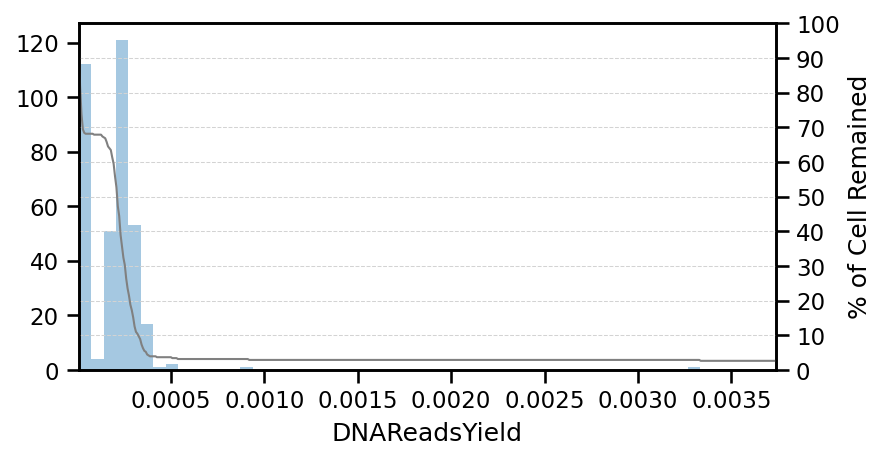

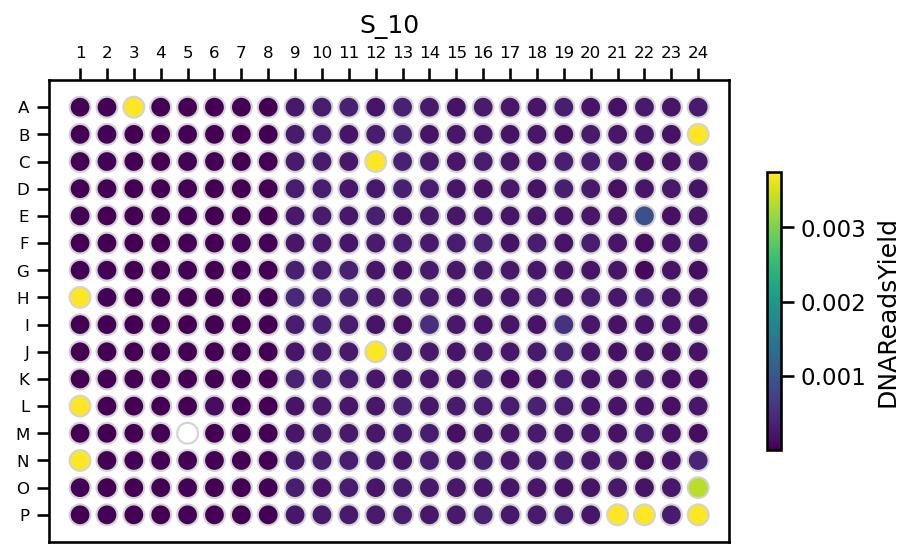

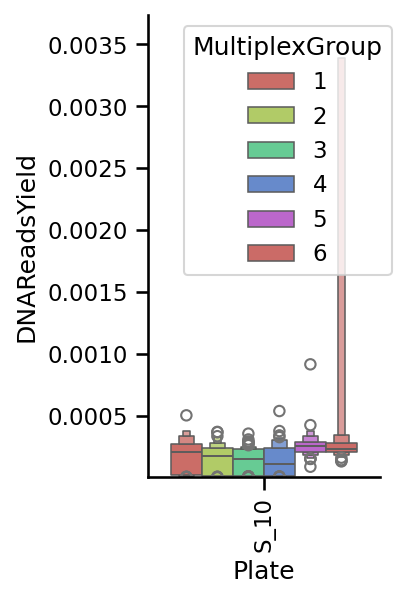

In [9]:
distplot_and_plate_view(mapping_summary, hue='DNAReadsYield')

### RNA Yield

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


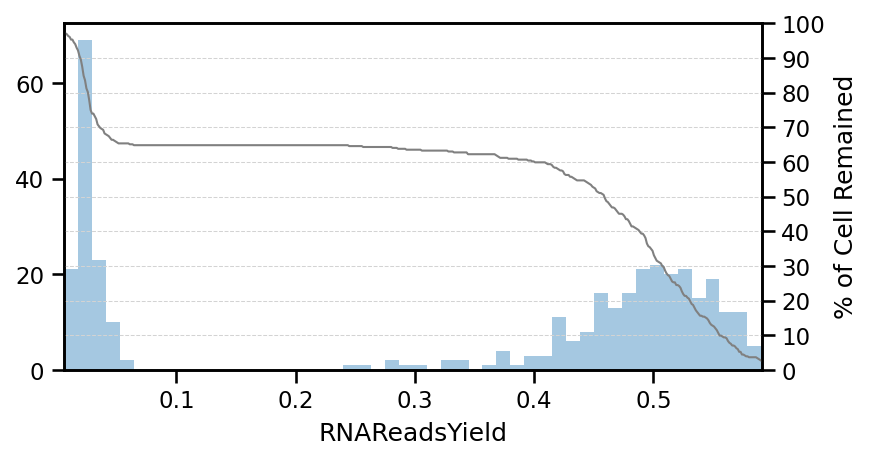

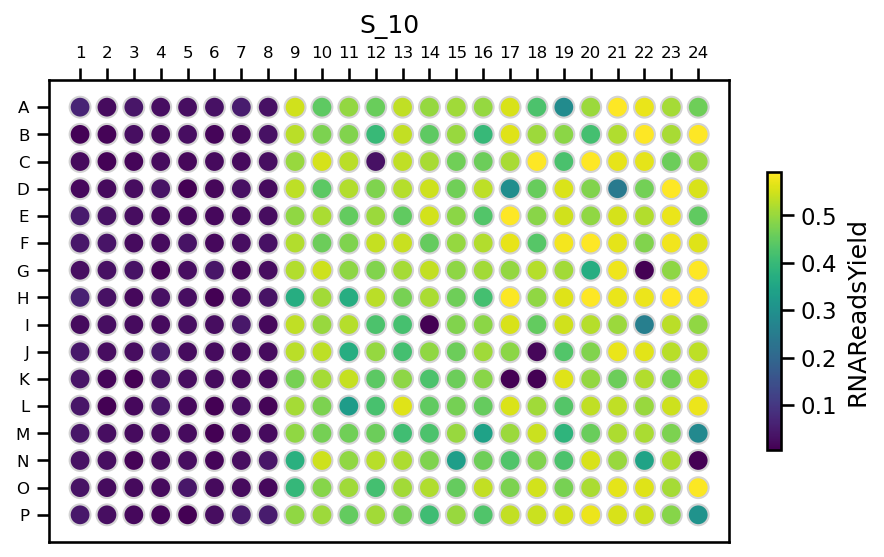

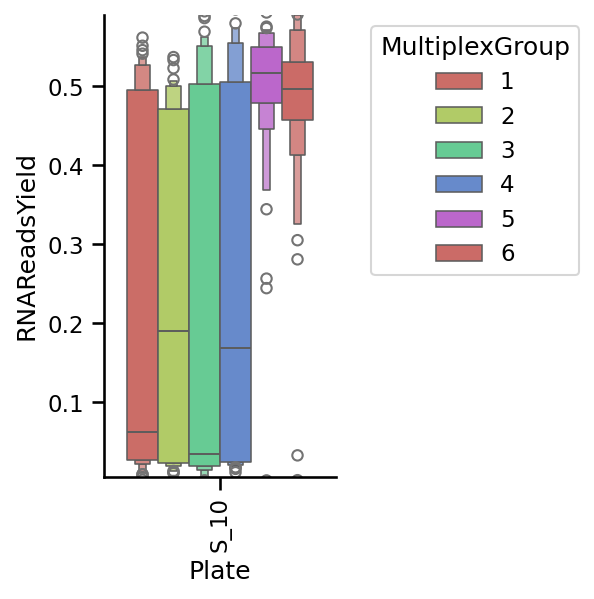

In [10]:
distplot_and_plate_view(mapping_summary, hue='RNAReadsYield')

### RNA / (DNA + RNA)

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


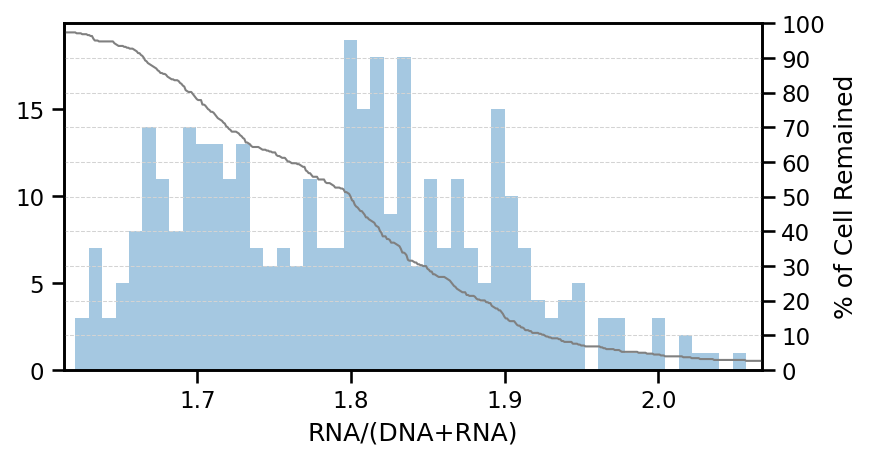

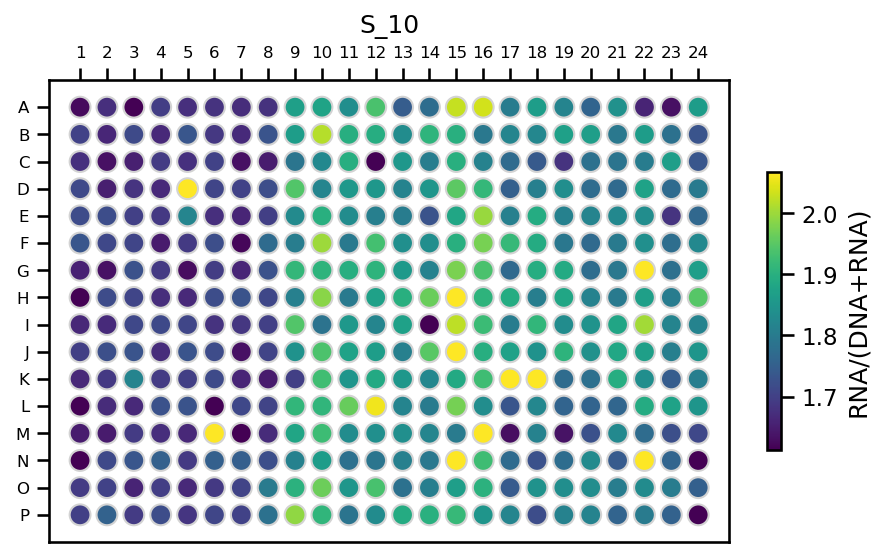

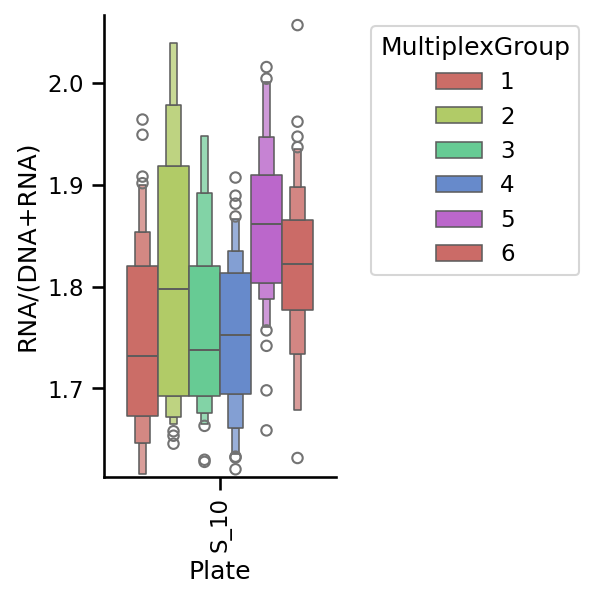

In [11]:
distplot_and_plate_view(mapping_summary, hue='RNA/(DNA+RNA)')

## mC Fraction

### mCCC

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


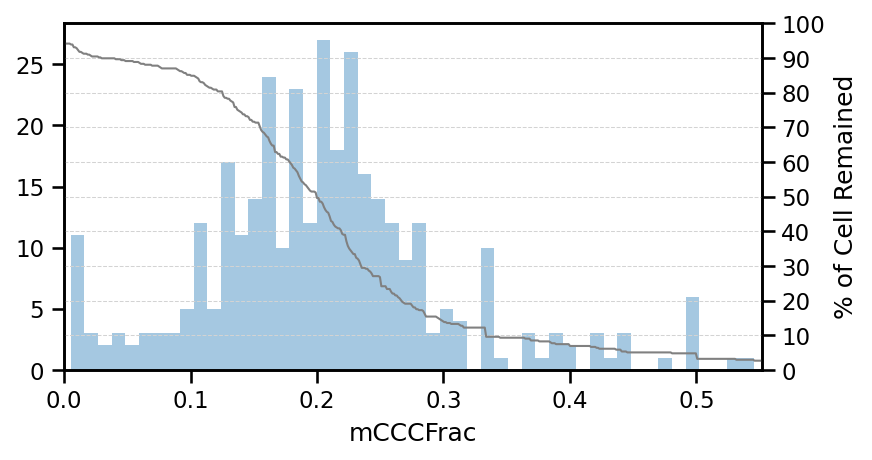

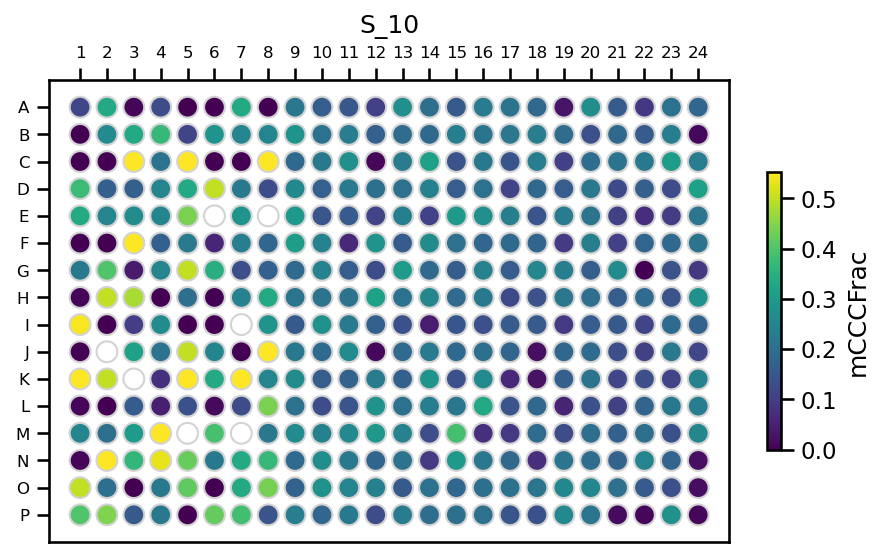

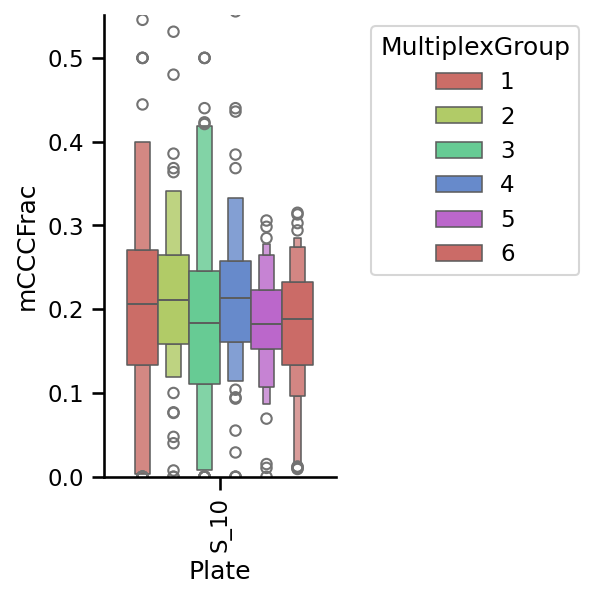

In [12]:
distplot_and_plate_view(mapping_summary, hue='mCCCFrac')

### mCH

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


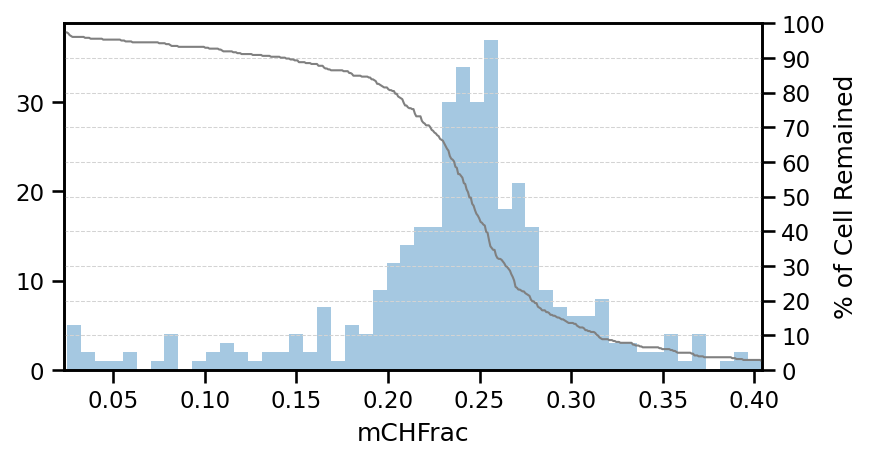

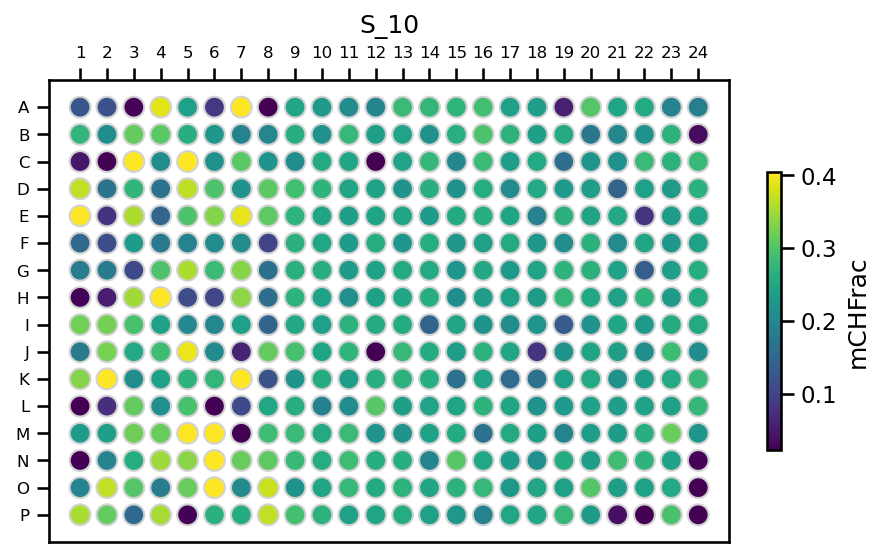

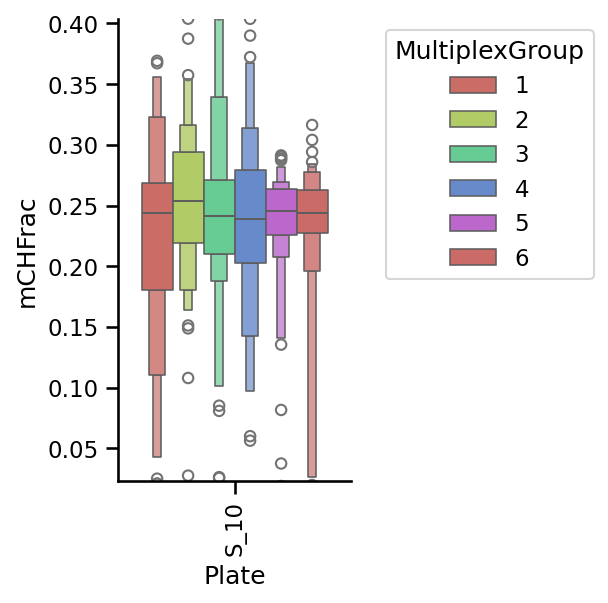

In [13]:
distplot_and_plate_view(mapping_summary, hue='mCHFrac')

### mCG

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


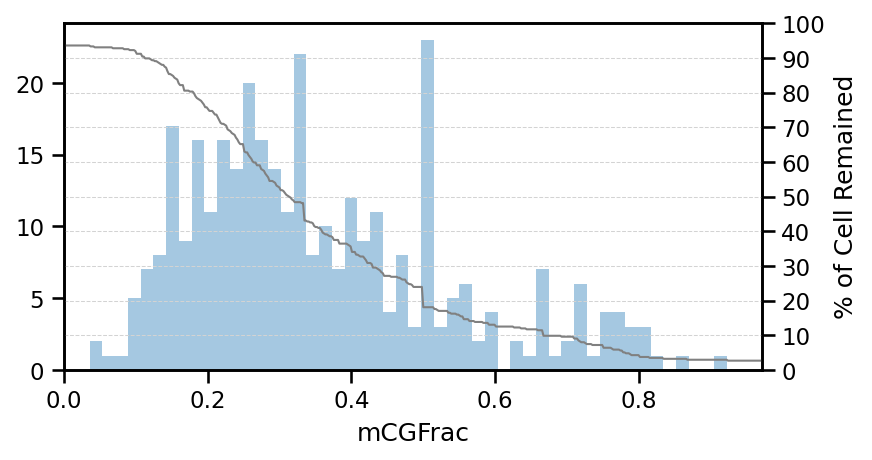

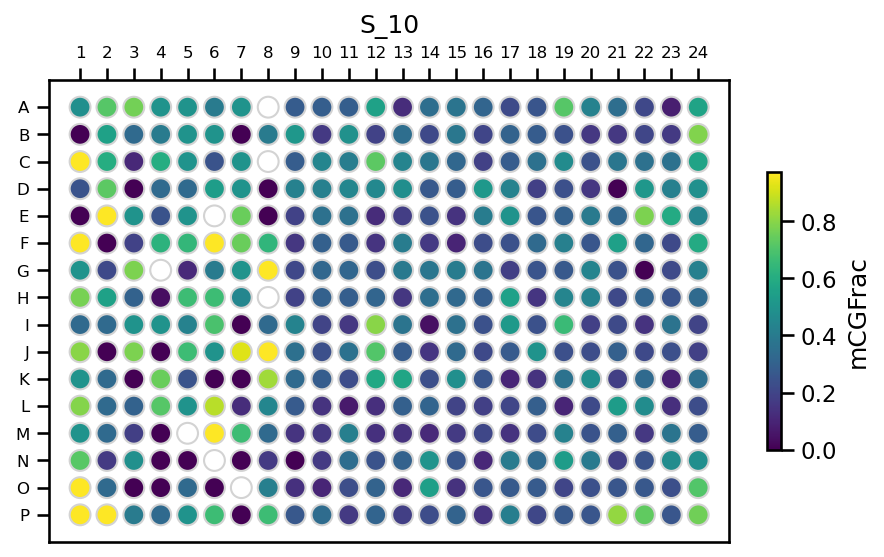

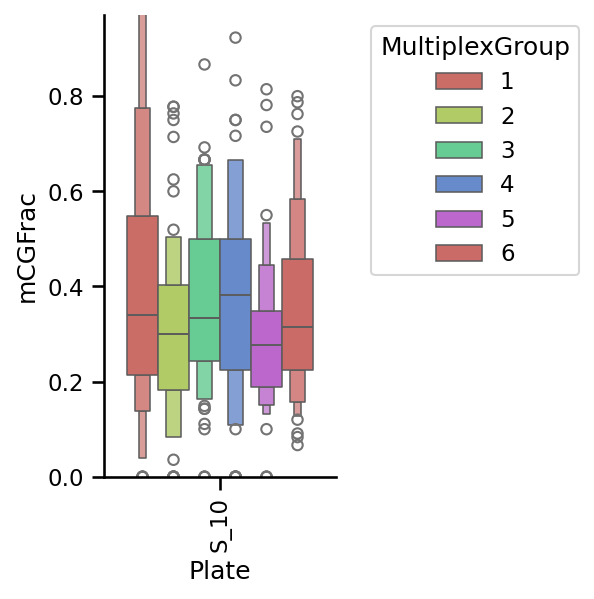

In [14]:
distplot_and_plate_view(mapping_summary, hue='mCGFrac')

## FASTQ Metric

### CellInputReadPairs

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


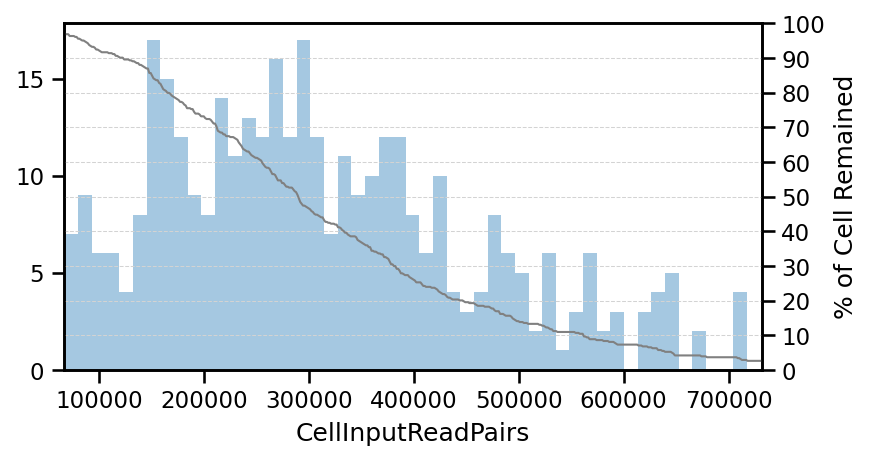

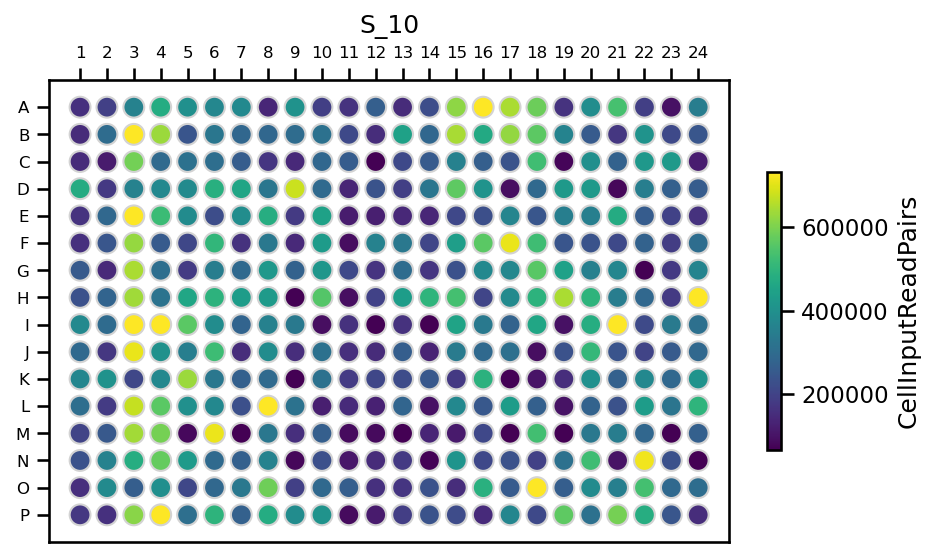

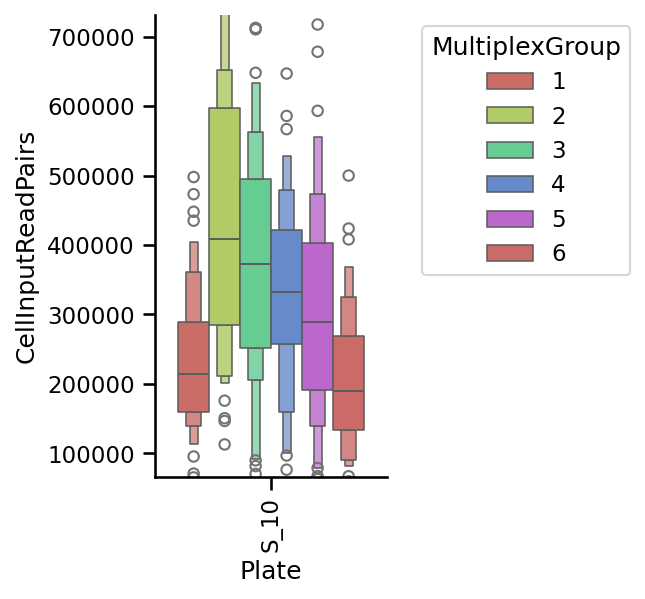

In [15]:
distplot_and_plate_view(mapping_summary, hue='CellInputReadPairs')

### Cell Barcode Portion

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


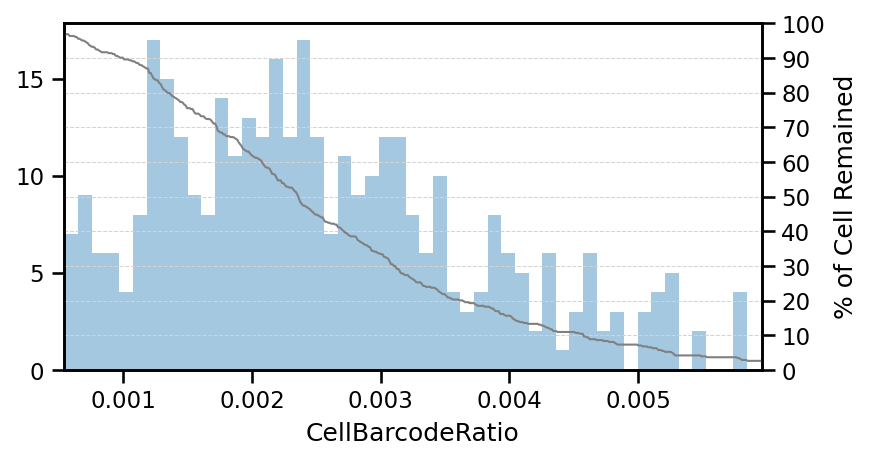

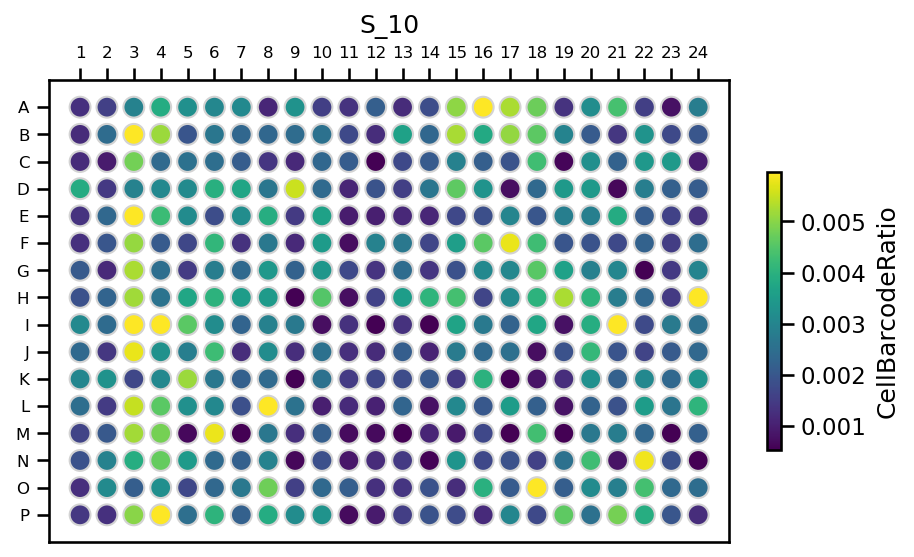

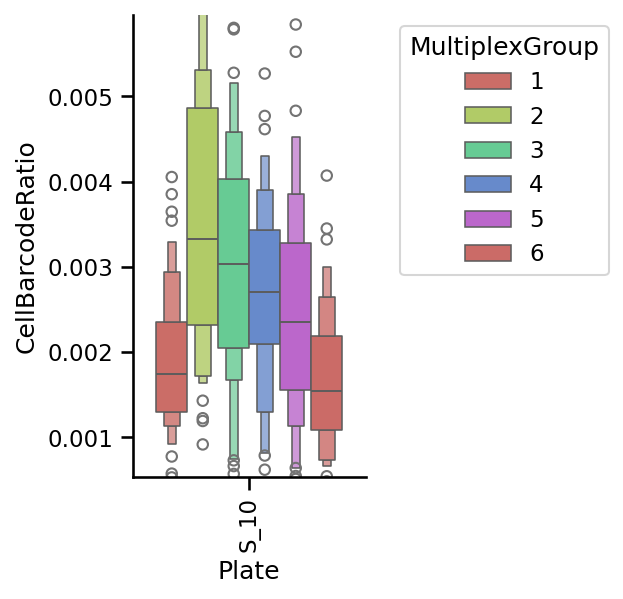

In [16]:
try:
    distplot_and_plate_view(mapping_summary, hue='CellBarcodeRatio')
except:
    pass

## Mapping Rate

### R1 Bismark Mapping Rate

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


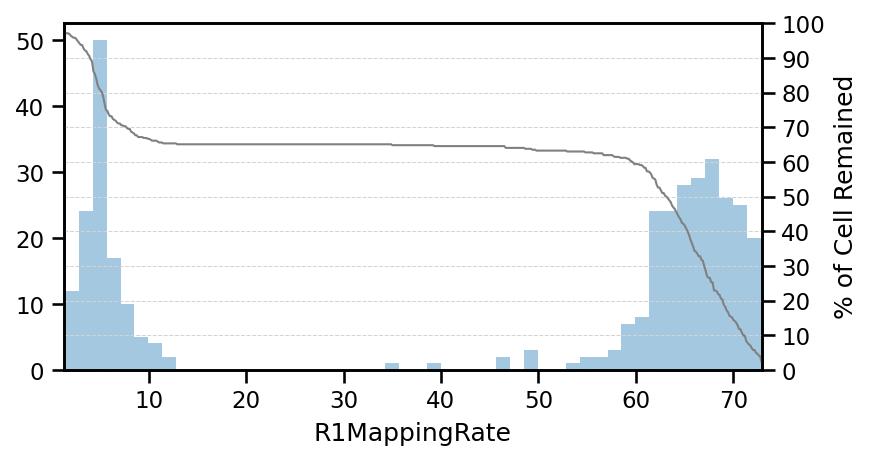

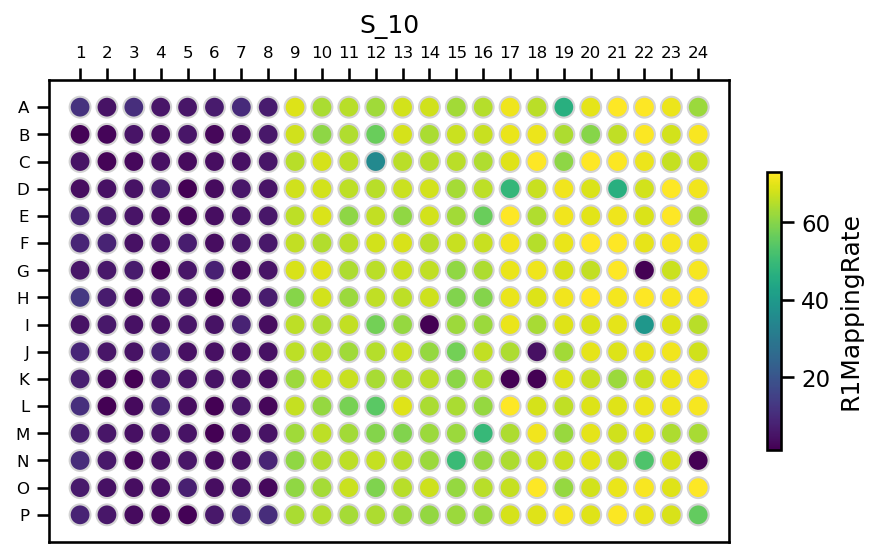

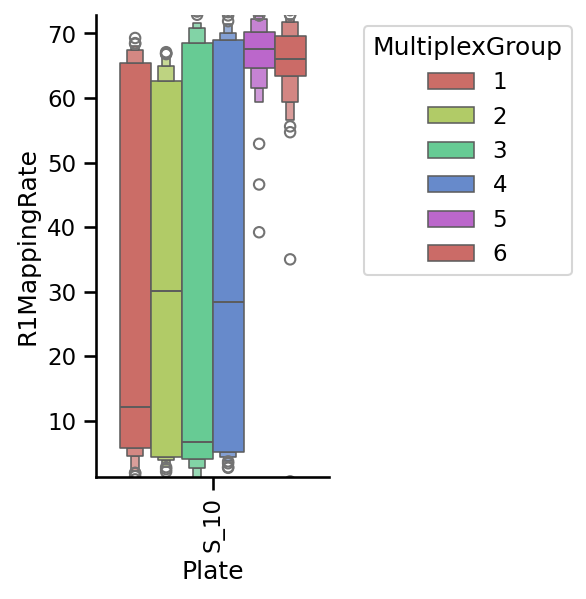

In [17]:
try:
    distplot_and_plate_view(mapping_summary, hue='R1MappingRate')
except:
    distplot_and_plate_view(mapping_summary, hue='DNAOverallMappingRate')

## PCR Duplication Rate

### R1 PCR Duplication Rate

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


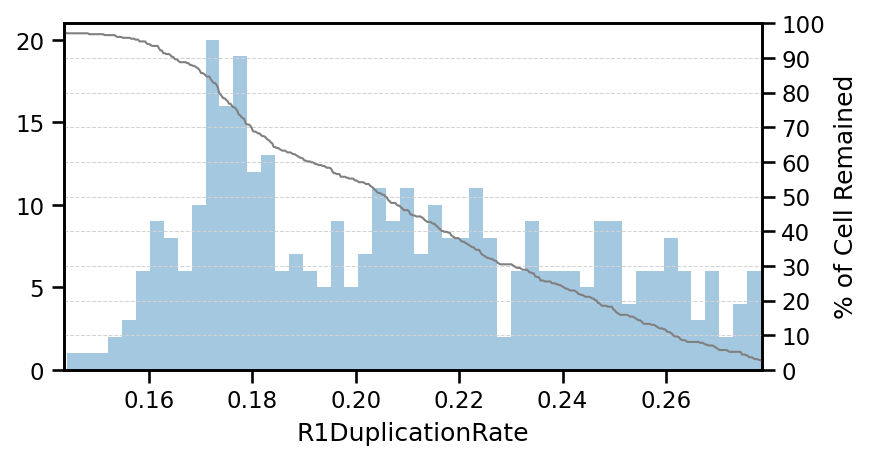

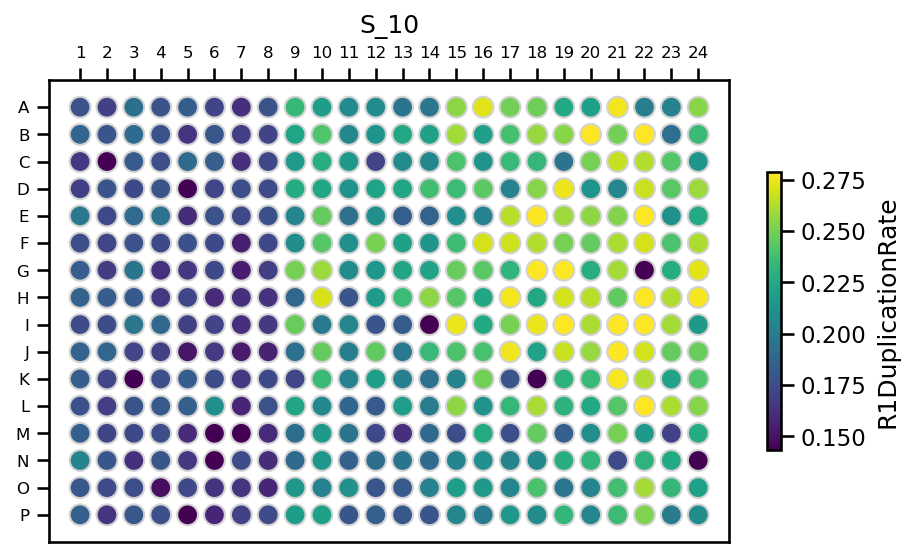

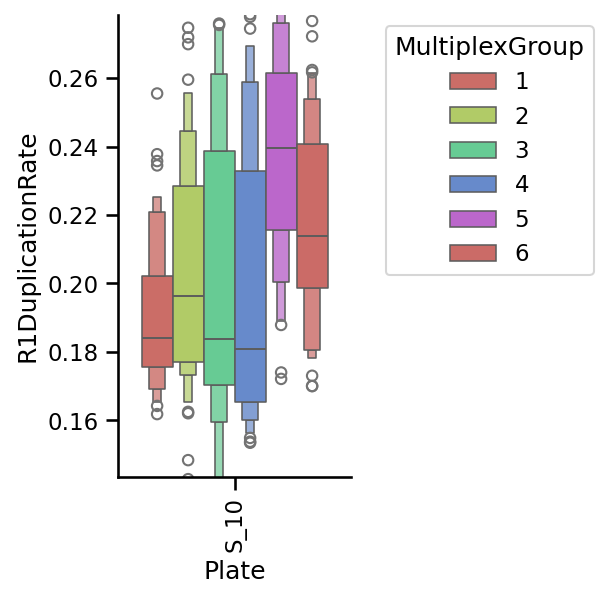

In [18]:
try:
    distplot_and_plate_view(mapping_summary, hue='R1DuplicationRate')
except:
    distplot_and_plate_view(mapping_summary, hue='DNAUniqueAlignPCRDuplicationRate')

## Final Reads

### DNA (mC) Reads

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


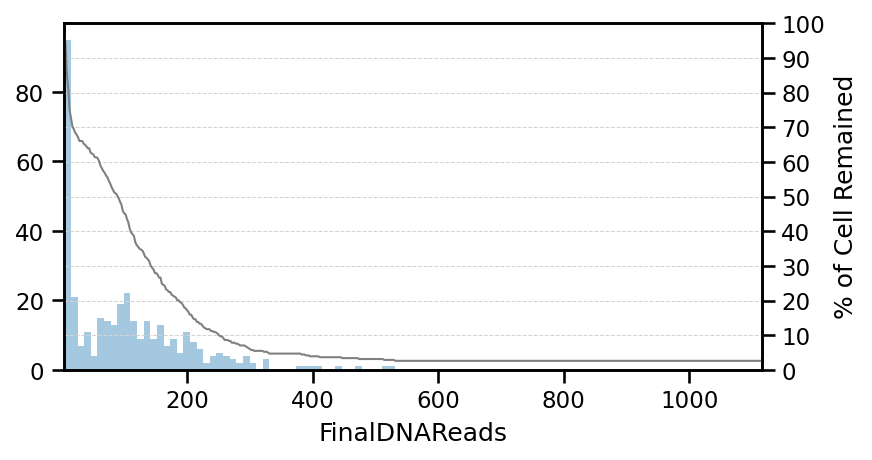

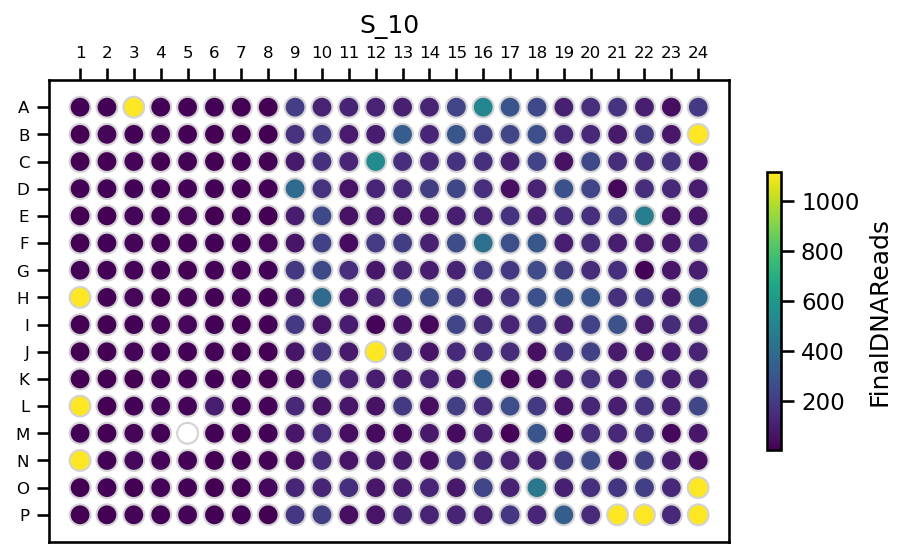

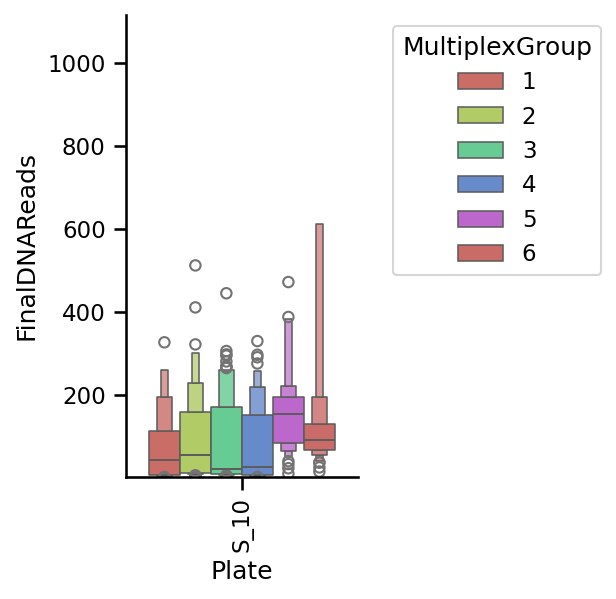

In [19]:
distplot_and_plate_view(mapping_summary, hue='FinalDNAReads')

### RNA Reads (R1)

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


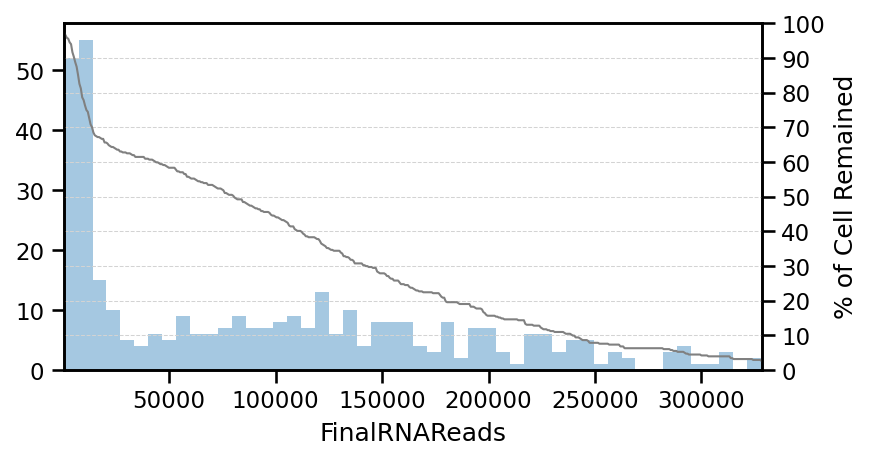

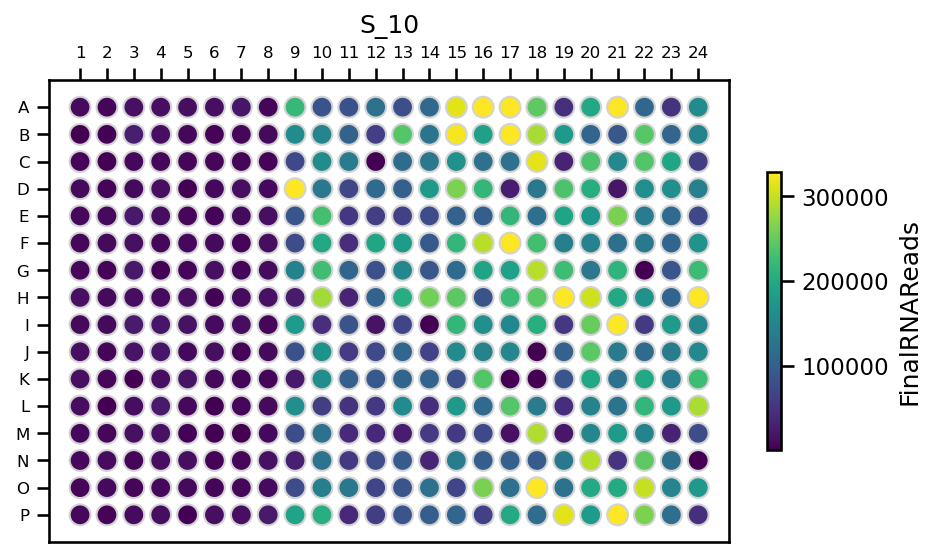

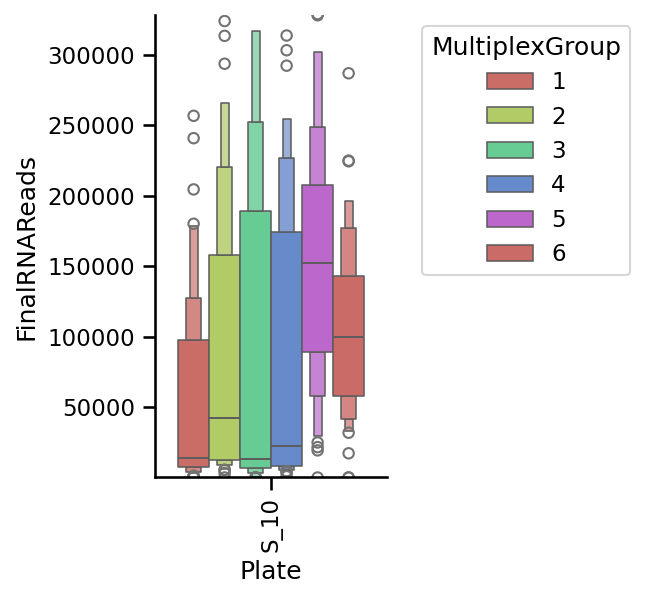

In [20]:
distplot_and_plate_view(mapping_summary, hue='FinalRNAReads')

### Genes Detected

/gpfs/home/asun/miniforge3/envs/yap/lib/python3.8/site-packages/cemba_data/mapping/stats/plot.py:142: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(data, bins=bins, kde=kde, ax=ax1)


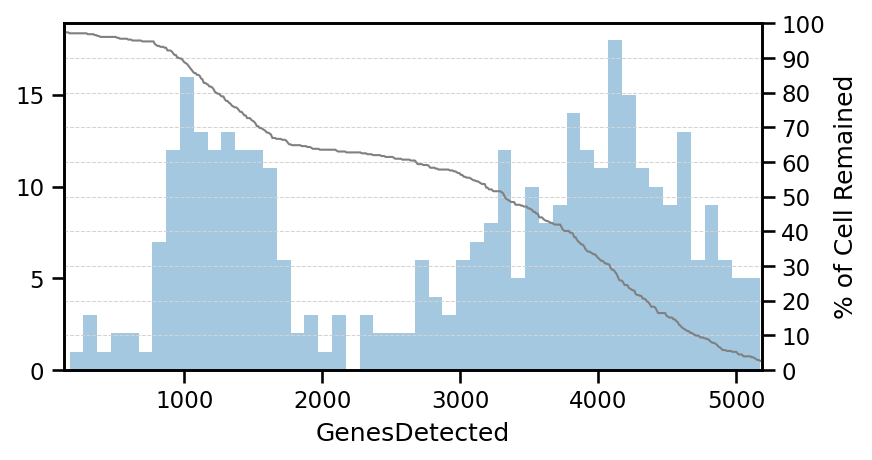

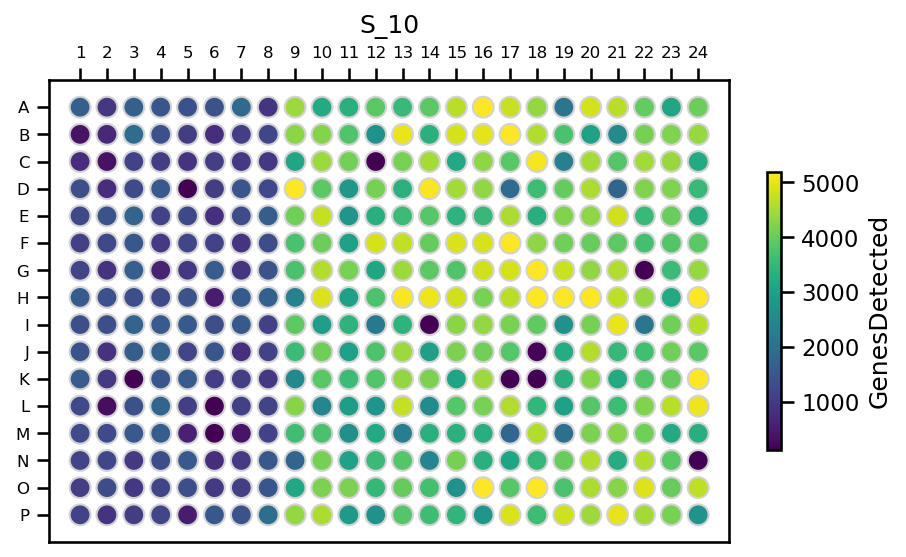

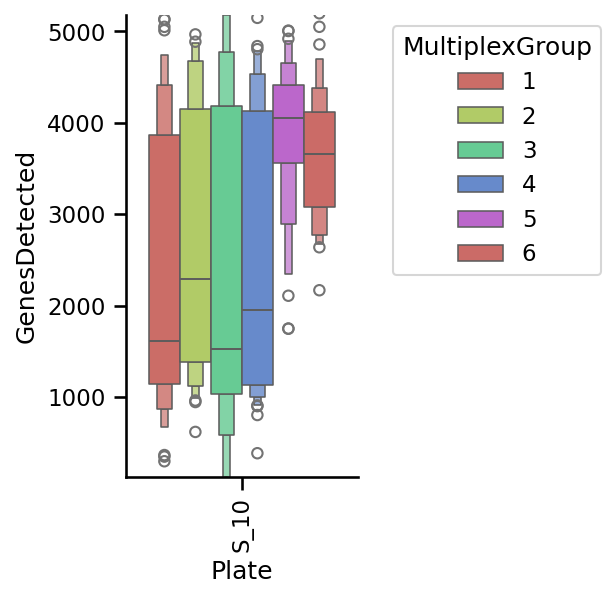

In [21]:
distplot_and_plate_view(mapping_summary, hue='GenesDetected')

## Mapping config

In [22]:
config

{'mode': 'mct',
 'barcode_version': 'V2',
 'r1_adapter': 'AGATCGGAAGAGCACACGTCTGAAC',
 'r2_adapter': 'AGATCGGAAGAGCGTCGTGTAGGGA',
 'overlap': '6',
 'r1_left_cut': '10',
 'r1_right_cut': '10',
 'r2_left_cut': '10',
 'r2_right_cut': '10',
 'quality_threshold': '20',
 'length_threshold': '30',
 'total_read_pairs_min': '1',
 'total_read_pairs_max': '6000000',
 'bismark_reference': '~/jin_lab/yap/raw_data/ref_w_chrG',
 'hisat3n_dna_reference': 'CHANGE_THIS_TO_YOUR_HISAT3N_DNA_REFERENCE',
 'hisat3n_rna_reference': 'CHANGE_THIS_TO_YOUR_HISAT3N_RNA_REFERENCE',
 'hisat3n_repeat_index_type': 'no-repeat',
 'unmapped_fastq': 'False',
 'star_reference': '~/jin_lab/yap/raw_data/ref_w_chrG/star',
 'mapq_threshold': '10',
 'mc_rate_max_threshold': '0.5',
 'dna_cov_min_threshold': '3',
 'mc_rate_min_threshold': '0.9',
 'rna_cov_min_threshold': '3',
 'nome_flag_str': '',
 'reference_fasta': '~/jin_lab/yap/raw_data/ref_w_chrG/mm10_no_alt_ENCODE_chrL_chrG.fa',
 'num_upstr_bases': '0',
 'num_downstr_bases'